In [1]:
import numpy as np
import argparse
import time
import os
import collections
import json
import queue
import time

from utils.data_utils import load_dataset_numpy

import scipy.spatial.distance
import networkx as nx
from scipy.sparse import csr_matrix, coo_matrix
from scipy.sparse.csgraph import maximum_flow
from utils.flow import _make_edge_pointers

from cvxopt import solvers, matrix, spdiag, log, mul, sparse, spmatrix

In [2]:
def minll(G,h,p):
    m,v_in=G.size
    def F(x=None,z=None):
        if x is None:
            return 0, matrix(1.0,(v,1))
        if min(x)<=0.0:
            return None
        f = -sum(mul(p,log(x)))
        Df = mul(p.T,-(x**-1).T)
        if z is None:
            return f,Df
        # Fix the Hessian
        H = spdiag(z[0]*mul(p,x**-2))
        return f,Df,H
    return solvers.cp(F,G=G,h=h)

In [3]:
def find_remaining_cap_edges(edge_ptr,capacities,heads,tails, source, sink):
    ITYPE = np.int32
    n_verts = edge_ptr.shape[0] - 1
    n_edges = capacities.shape[0]
    ITYPE_MAX = np.iinfo(ITYPE).max

    # Our result array will keep track of the flow along each edge
    flow = np.zeros(n_edges, dtype=ITYPE)

    # Create a circular queue for breadth-first search. Elements are
    # popped dequeued at index start and queued at index end.
    q = np.empty(n_verts, dtype=ITYPE)

    # Create an array indexing predecessor edges
    pred_edge = np.empty(n_verts, dtype=ITYPE)

    # While augmenting paths from source to sink exist
    for k in range(n_verts):
        pred_edge[k] = -1
    path_edges = []
    # Reset queue to consist only of source
    q[0] = source
    start = 0
    end = 1
    # While we have not found a path, and queue is not empty
    path_found = False
    while start != end and not path_found:
        # Pop queue
        cur = q[start]
        start += 1
        if start == n_verts:
            start = 0
        # Loop over all edges from the current vertex
        for e in range(edge_ptr[cur], edge_ptr[cur + 1]):
            t = heads[e]
            if pred_edge[t] == -1 and t != source and\
                    capacities[e] > flow[e]:
                pred_edge[t] = e
                path_edges.append((cur,t))
                if t == sink:
                    path_found = True
                    break
                # Push to queue
                q[end] = t
                end += 1
                if end == n_verts:
                    end = 0
    return path_edges


In [4]:
def create_graph_rep(edge_matrix,n_1,n_2,weights):
    graph_rep = []
    for i in range(n_1+n_2+2):
        graph_rep.append([])
        if i==0:
            #source
            for j in range(n_1+n_2+2):
                if j==0:
                    graph_rep[i].append(0)
                elif 1<=j<=n_1:
                    graph_rep[i].append(weights[j-1])
                elif n_1<j<=n_1+n_2+1:
                    graph_rep[i].append(0)
        elif 1<=i<=n_1:
            # LHS vertices
            for j in range(n_1+n_2+2):
                if j<=n_1:
                    graph_rep[i].append(0)
                elif n_1<j<=n_1+n_2:
                    if edge_matrix[i-1,j-n_1-1]:
                        graph_rep[i].append(1)
                    else:
                        graph_rep[i].append(0)
                elif n_1+n_2<j:
                    graph_rep[i].append(0)
        elif n_1<i<=n_1+n_2:
            #RHS vertices
            for j in range(n_1+n_2+2):
                if j<=n_1+n_2:
                    graph_rep[i].append(0)
                elif j>n_1+n_2:
                    graph_rep[i].append(weights[i-1])
        elif i==n_1+n_2+1:
            #Sink
            for j in range(n_1+n_2+2):
                graph_rep[i].append(0)

    graph_rep_array=np.array(graph_rep)

    return graph_rep_array


In [5]:
import networkx as nx

def create_graph_rep(edge_matrix, n_1, n_2, weights, top_indices):
    graph_rep = nx.DiGraph()

    # Calculate the total demand for selected nodes in the first set (top_indices)
    selected_demand_n1 = sum(weights[i - 1] for i in top_indices if i <= n_1)

    # Calculate the total demand for selected nodes in the second set (top_indices)
    selected_demand_n2 = sum(weights[i - 1] for i in top_indices if i > n_1 and i <= n_1 + n_2)

    # Add source node # set demand to -(sum of weights upto n_1 for selected nodes)
    graph_rep.add_node(0, demand=-(selected_demand_n1*selected_demand_n2))
    
    # Add nodes specified in top_indices
    graph_rep.add_nodes_from(top_indices)

    # Add sink node # sum of weights from n_1 to n_2 for selected nodes
    graph_rep.add_node(n_1 + n_2 + 1, demand=(selected_demand_n1*selected_demand_n2))

    # Add edges with costs and capacities
    for i in range(1, n_1 + 1):
        for j in range(n_1 + 1, n_1 + n_2 + 1):
            if edge_matrix[i - 1, j - 1] and i in top_indices and j in top_indices:
                graph_rep.add_edge(i, j, weight=0)

    # Set costs and capacities for edges from source and to sink
    for i in range(1, n_1 + 1):
        if i in top_indices:
            graph_rep.add_edge(0, i, capacity=(weights[i - 1]*selected_demand_n2))

    for i in range(n_1 + 1, n_1 + n_2 + 1):
        if i in top_indices:
            graph_rep.add_edge(i, n_1 + n_2 + 1, capacity=(weights[i - 1]*selected_demand_n1))

    # Add new edge between source and sink with cost 1 and capacity infinity
    graph_rep.add_edge(0, n_1 + n_2 + 1, weight=1)

    return graph_rep


In [6]:
edge_matrix = np.array([[0, 1, 1], [1, 0, 1], [1, 1, 0]])
n_1 = 2
n_2 = 1
weights = [1, 2, 3]
top_indices = [1, 3]
graph_rep = create_graph_rep(edge_matrix, n_1, n_2, weights,top_indices)
print(type(graph_rep))
cost_sol=nx.min_cost_flow(graph_rep)

<class 'networkx.classes.digraph.DiGraph'>


In [7]:
cost_sol

{0: {1: 3, 4: 0}, 1: {3: 3}, 3: {4: 3}, 4: {}}

In [8]:
graph_rep.edges[(1,3)]

{'weight': 0}

In [9]:
nx.cost_of_flow(graph_rep,cost_sol)

0

In [10]:
def set_classifier_prob_full_flow(top_level_vertices,w_1_curr,w_2_curr):
    for item in top_level_vertices:
        if item !=0 and item != sink_idx:
            classifier_probs[item-1,0]=w_1_curr/(w_1_curr+w_2_curr)
            classifier_probs[item-1,1]=w_2_curr/(w_1_curr+w_2_curr)

In [11]:
def set_classifier_prob_no_flow(top_level_vertices):
    for item in top_level_vertices:
        if item !=0 and item != sink_idx:
            if item<=n_1:
                classifier_probs[item-1,0]=1
                classifier_probs[item-1,1]=0
            elif item>n_1:
                classifier_probs[item-1,0]=0
                classifier_probs[item-1,1]=1

In [17]:
def graph_rescale(graph_rep_curr,top_level_indices,weights):
    class_1_vertices=top_level_indices[( top_level_indices> 0) & (top_level_indices<=n_1)]
    class_1_weights=weights[class_1_vertices-1]
    w_1_curr=np.sum(class_1_weights)
    class_2_vertices=top_level_indices[ (top_level_indices>n_1) & (top_level_indices<=n_1+n_2)]
    class_2_weights=weights[class_2_vertices-1]
    w_2_curr=np.sum(class_2_weights)
    n_1_curr=len(class_1_vertices)
    n_2_curr=len(class_2_vertices)
    #n_1_curr=len(np.where(top_level_indices<=n_1)[0])-1
    #n_2_curr=len(np.where(top_level_indices>n_1)[0])-1
    # source rescale
    # print(graph_rep_curr[0])
    #graph_rep_curr[0,:]=graph_rep_curr[0,:]/n_2
    graph_rep_curr[0,:]= (graph_rep_curr[0,:]*w_2_curr)
    # print(graph_rep_curr[0])
    # bipartite graph edge scale
    #graph_rep_curr[1:n_1_curr+1,:]=graph_rep_curr[1:n_1_curr+1,:]/(n_1*n_2)
    graph_rep_curr[1:n_1_curr+1,:]=(graph_rep_curr[1:n_1_curr+1,:]*(w_1_curr*w_2_curr))
    # sink edges rescale
    #graph_rep_curr[n_1_curr+1:,:]=graph_rep_curr[n_1_curr+1:,:]/n_1
    graph_rep_curr[n_1_curr+1:,:]=(graph_rep_curr[n_1_curr+1:,:]*w_1_curr)
    #print(f"The graph_rep_curr is {graph_rep_curr}, w_1_curr is : {w_1_curr},w_2_curr is : {w_2_curr}")
    return graph_rep_curr,w_1_curr,w_2_curr

In [147]:
def find_flow_and_split(top_level_indices,weights):
    top_level_indices_1=None
    top_level_indices_2=None
    #Create subgraph from index array provided
    graph_rep_curr = graph_rep_array[top_level_indices]
    graph_rep_curr = graph_rep_curr[:,top_level_indices]
    graph_rep_curr,w_1_curr,w_2_curr = graph_rescale(graph_rep_curr,top_level_indices,weights)
    print(f"The weight1 is : {w_1_curr} , the weight2 is:{w_2_curr}")
    G=networkx_graph(graph_rep_curr)
    flow_dict = nx.min_cost_flow(G) # Calculate the minimum cost flow
    flow_value = flow_dict[0][len(top_level_indices)-1] # Extract the flow value
    #flow_curr = maximum_flow(graph_curr,0,len(top_level_indices)-1)
    print(f"The flow value is:{flow_value}")
    # Checking if full flow occurred, so no need to split
    if flow_value==0:
        set_classifier_prob_no_flow(top_level_indices)
        return top_level_indices_1,top_level_indices_2, flow_curr
    elif flow_value==w_1_curr*w_2_curr:
        if (w_1_curr*w_2_curr)>=2**32:
            print("There is overflow")
        set_classifier_prob_full_flow(top_level_indices,w_1_curr,w_2_curr)
        return top_level_indices_1,top_level_indices_2, flow_value
    # Finding remaining capacity edges
    remainder_array = graph_curr-flow_curr.residual
    #print(f"The remainder array is :{ remainder_array}")

    rev_edge_ptr, tails = _make_edge_pointers(remainder_array)
    #print(f"The rev_edge and tails are : {rev_edge_ptr} and {tails}")
    edge_ptr=remainder_array.indptr
    capacities=remainder_array.data
    heads=remainder_array.indices

    edge_list_curr = find_remaining_cap_edges(edge_ptr,capacities,heads,tails,0,len(top_level_indices)-1)

    #print(f"The edge_list_curr is {edge_list_curr}")
    gz_idx = []
    for item in edge_list_curr:
        gz_idx.append(item[0])
        gz_idx.append(item[1])
    #print(f"The gz_idx is {gz_idx}")
    if len(gz_idx)>0:
        gz_idx=np.array(gz_idx)
        gz_idx_unique=np.unique(gz_idx)
        top_level_gz_idx=top_level_indices[gz_idx_unique]
        top_level_gz_idx=np.insert(top_level_gz_idx,len(top_level_gz_idx),sink_idx)
        top_level_indices_1=top_level_gz_idx
    else:
        top_level_gz_idx=np.array([0,sink_idx])
    # Indices without flow
    top_level_z_idx=np.setdiff1d(top_level_indices,top_level_gz_idx)
    if len(top_level_z_idx)>0:
        # Add source and sink back to zero flow idx array
        top_level_z_idx=np.insert(top_level_z_idx,0,0)
        top_level_z_idx=np.insert(top_level_z_idx,len(top_level_z_idx),sink_idx)
        top_level_indices_2=top_level_z_idx
    #print(top_level_indices_1, top_level_indices_2, flow_curr)
    return top_level_indices_1,top_level_indices_2, flow_curr

In [151]:
parser = argparse.ArgumentParser()

In [152]:
parser.add_argument("--dataset_in", default='MNIST',
                    help="dataset to be used")
parser.add_argument("--norm", default='l2',
                    help="norm to be used")
parser.add_argument('--num_samples', type=int, default=None)
parser.add_argument('--n_classes', type=int, default=2)
parser.add_argument('--eps', type=str, default=None)
parser.add_argument('--approx_only', dest='approx_only', action='store_true')
parser.add_argument('--use_test', dest='use_test', action='store_true')
parser.add_argument('--track_hard', dest='track_hard', action='store_true')
parser.add_argument('--use_full', dest='use_full', action='store_true')
parser.add_argument('--run_generic', dest='run_generic', action='store_true')
parser.add_argument('--new_marking_strat', type=str, default=None)
parser.add_argument('--num_reps', type=int, default=2)
parser.add_argument('--class_1', type=int, default=3)
parser.add_argument('--class_2', type=int, default=7)

_StoreAction(option_strings=['--class_2'], dest='class_2', nargs=None, const=None, default=7, type=<class 'int'>, choices=None, help=None, metavar=None)

In [153]:
args = parser.parse_args("--dataset_in=MNIST --num_samples=2500 --use_full --eps=0,4".split())

In [154]:
args

Namespace(approx_only=False, class_1=3, class_2=7, dataset_in='MNIST', eps='0,4', n_classes=2, new_marking_strat=None, norm='l2', num_reps=2, num_samples=2500, run_generic=False, track_hard=False, use_full=True, use_test=False)

In [155]:
eps=args.eps

In [156]:
eps

'0,4'

In [157]:
eps=eps.split(',')
eps

['0', '4']

In [158]:
eps=[float(i) for i in eps]
eps

[0.0, 4.0]

In [159]:
train_data, test_data, data_details = load_dataset_numpy(args, data_dir='data',
                                                        training_time=False)

In [160]:
train_data

Dataset MNIST
    Number of datapoints: 5000
    Root location: data
    Split: Train

In [161]:
test_data

Dataset MNIST
    Number of datapoints: 2020
    Root location: data
    Split: Test

In [162]:
data_details

{'n_channels': 1, 'h_in': 28, 'w_in': 28, 'scale': 255.0}

In [163]:
DATA_DIM = data_details['n_channels']*data_details['h_in']*data_details['w_in']

X = []
Y = []

# Pytorch normalizes tensors (so need manual here!)
if args.use_test:
    for (x,y,_, _, _) in test_data:
        X.append(x/255.)
        Y.append(y)
else:
    for (x,y,_, _, _) in train_data:
        X.append(x/255.)
        Y.append(y)

X = np.array(X)
Y = np.array(Y)

num_samples = int(len(X)/2)
print(num_samples)

2500


In [164]:
X_c1 = X[:num_samples].reshape(num_samples, DATA_DIM)
X_c2 = X[num_samples:].reshape(num_samples, DATA_DIM)

class_1 = args.class_1
class_2 = args.class_2

if not os.path.exists('distances'):
    os.makedirs('distances')

if not os.path.exists('cost_results'):
    os.makedirs('cost_results')

if args.use_full:
    subsample_sizes = [args.num_samples]
else:
    subsample_sizes = [args.num_samples]
   

rng = np.random.default_rng(77)

In [165]:
subsample_sizes

[2500]

In [167]:
eps=[3.5]

In [59]:
#eps[0][0][1]

In [60]:
#eps_user=[[0,1],[0,2],[0,3],[0,4],[0,5],[0,6],[0,7],[0,8],[0,9],[0,10],[0,11],[0,12]]

In [24]:
import MultipleBudgetEdgeMatrix

In [168]:
from tqdm import tqdm

In [169]:
import math

In [170]:
loss_final=[]
weight_list=[]
avg_list_loss_adversary1=[]
avg_list_loss_adversary2=[]
loss_final_100=[]
for i in tqdm(range(0,100)):
  if subsample_sizes == args.num_samples:
        num_reps=1
  else:
        num_reps=args.num_reps
  for rep in range(num_reps):
        indices_1 = rng.integers(num_samples,size=subsample_sizes)
        indices_2 = rng.integers(num_samples, size=subsample_sizes)
  sub_indices_1 = [0 for x in range(subsample_sizes[0])]
  sub_indices_2 = [0 for x in range(subsample_sizes[0])]
  for i in range(indices_1.shape[0]):
    sub_indices_1[indices_1[i]]+=1
    sub_indices_2[indices_2[i]]+=1
  weights=np.array(sub_indices_1+sub_indices_2)
  
 
  for subsample_size in subsample_sizes:
  
    
    loss_list = []
    time_list = []
    num_edges_list = []

    if args.run_generic:
        time_generic_list = []

    if subsample_size == args.num_samples:
        num_reps=1
    else:
        num_reps=args.num_reps
    for rep in range(num_reps):
        X_c1_curr = X_c1[indices_1]
        X_c2_curr = X_c2[indices_2]

        if args.use_test:
            dist_mat_name = args.dataset_in + '_test_' + str(class_1) + '_' + str(class_2) + '_' + str(subsample_size) + '_' + args.norm + '_rep' + str(rep) + '.npy'
        else:
            dist_mat_name = args.dataset_in + '_' + str(class_1) + '_' + str(class_2) + '_' + str(subsample_size) + '_' + args.norm + '_rep' + str(rep) + '.npy'
        if os.path.exists(dist_mat_name):
            print('Loading distances')
            D_12 = np.load('distances/' + dist_mat_name)
        else:
            if args.norm == 'l2':
                D_12 = scipy.spatial.distance.cdist(X_c1_curr,X_c2_curr,metric='euclidean')
            elif args.norm == 'linf':
                D_12 = scipy.spatial.distance.cdist(X_c1_curr,X_c2_curr,metric='chebyshev')
            np.save('distances/' + dist_mat_name, D_12)

        for m in range(len(eps)):
         # Add edge if cost 0
         edge_matrix = D_12 <= 2*eps[m]
         edge_matrix = edge_matrix.astype(float)

         num_edges = len(np.where(edge_matrix!=0)[0])
         print(num_edges,eps[m])
         num_edges_list.append(num_edges)

         n_1=subsample_size
         n_2=subsample_size

         # Create graph representation
         graph_rep_array = create_graph_rep(edge_matrix,n_1,n_2,weights)

         time1= time.clock()
         q = queue.Queue()
         # Initial graph indices
         q.put(np.arange(n_1+n_2+2))
         sink_idx=n_1+n_2+1
         count=0
         classifier_probs=np.zeros(((n_1)+(n_2),2))
         while not q.empty():
            print('Current queue size at eps %s is %s' % (eps[m],q.qsize()))
            curr_idx_list=q.get()
            # print(q.qsize())
            list_1, list_2, flow_curr=find_flow_and_split(curr_idx_list,weights)
            # print(list_1,list_2,flow_curr.flow_value)
            if list_1 is not None:
                q.put(list_1)
            if list_2 is not None:
                q.put(list_2)
         time2 = time.clock()

         if args.run_generic:
            v=(n_1+n_2)
            num_edges=len(np.where(edge_matrix==1)[0])
            edges=np.where(edge_matrix==1)
            incidence_matrix=np.zeros((num_edges,v))

            for i in range(num_edges):
                j1=edges[0][i]
                j2=edges[1][i]+(n_1-1)
                incidence_matrix[i,j1]=1
                incidence_matrix[i,j2]=1

            G_in=np.vstack((incidence_matrix,np.eye(v)))
            h_in=np.ones((num_edges+v,1))
            p=(1.0/v)*np.ones((v,1))

            G_in_sparse_np=coo_matrix(G_in)

            G_in_sparse=spmatrix(1.0,G_in_sparse_np.nonzero()[0],G_in_sparse_np.nonzero()[1])

            solvers.options['maxiters']=1000

            time3=time.clock()
            output=minll(G_in_sparse,matrix(h_in),matrix(p))
            print(output['primal objective'])
            time4=time.clock()
            if output['status'] == 'optimal':
                time_generic_list.append(time4-time3)
            else:
                time_generic_list.append(-1.0*(time4-time3))
         loss_adversary1=0
         loss_adversary2=0
         for i in range(0,n_1//2):
                ans=np.log(classifier_probs[i][0])*weights[i]
                if math.isnan(ans)==True:
                 loss_adversary1+=0
                else:
                 loss_adversary1+=np.log(classifier_probs[i][0])*weights[i]
         for i in range(n_1//2,n_1):
                ans=np.log(classifier_probs[i][0])*weights[i]
                if math.isnan(ans) == True:
                    loss_adversary2+=0
                else:
                    loss_adversary2+=np.log(classifier_probs[i][0])*weights[i]
         for i in range(n_1,(n_1+(n_2//2))):
                ans=np.log(classifier_probs[i][1])*weights[i]
                if math.isnan(ans) == True:
                    loss_adversary1+=0
                else:
                    loss_adversary1+=np.log(classifier_probs[i][1])*weights[i]
         for i in range((n_1+(n_2//2)),n_1+n_2):
                ans=np.log(classifier_probs[i][1])*weights[i]
                if math.isnan(ans)==True:
                      loss_adversary2+=0
                else:
                      loss_adversary2+=np.log(classifier_probs[i][1])*weights[i]
           

         avg_loss_adversary1=-1*loss_adversary1/(np.sum(weights[0:n_1//2])+np.sum(weights[n_1:(n_1+(n_2//2))]))

         avg_loss_adversary2=-1*loss_adversary2/(np.sum(weights[n_1//2:n_1])+np.sum(weights[(n_1+(n_2//2)):n_1+n_2]))
         avg_list_loss_adversary1.append(avg_loss_adversary1)
         avg_list_loss_adversary2.append(avg_loss_adversary2)
         avg_loss=-1*(loss_adversary1+loss_adversary2)/(np.sum(weights))
         loss_final_100.append(avg_loss) 

         print('Log loss for eps %s is %s' % (eps,avg_loss))
         loss_final.append([eps,avg_loss_adversary1,avg_loss_adversary2,avg_loss,subsample_size])
         weight_list.append([np.sum(weights[0:n_1//2]),np.sum(weights[n_1:(n_1+(n_2//2))]),np.sum(weights[n_1//2:n_1]),np.sum(weights[(n_1+(n_2//2)):n_1+n_2])])
         time_list.append(time2-time1)

         

    loss_avg=np.mean(loss_list)
    loss_var=np.var(loss_list)
    time_avg=np.mean(time_list)
    time_var=np.var(time_list)
    num_edges_avg=np.mean(num_edges_list)

   

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

12550 3.5


c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Current queue size at eps 3.5 is 1
The weight1 is : 2500 , the weight2 is:2500
The flow value is:595000
Current queue size at eps 3.5 is 2
The weight1 is : 2296 , the weight2 is:34
The flow value is:3536
Current queue size at eps 3.5 is 3
The weight1 is : 204 , the weight2 is:2466
The flow value is:145134
Current queue size at eps 3.5 is 4
The weight1 is : 2192 , the weight2 is:0
The flow value is:0
Current queue size at eps 3.5 is 3
The weight1 is : 104 , the weight2 is:34
The flow value is:2322
Current queue size at eps 3.5 is 4
The weight1 is : 199 , the weight2 is:651
The flow value is:91272
Current queue size at eps 3.5 is 5
The weight1 is : 5 , the weight2 is:1815
The flow value is:590
Current queue size at eps 3.5 is 6
The weight1 is : 51 , the weight2 is:5
The flow value is:208
Current queue size at eps 3.5 is 7
The weight1 is : 53 , the weight2 is:29
The flow value is:1409
Current queue size at eps 3.5 is 8
The weight1 is : 145 , the weight2 is:282
The flow value is:36044
Curr

c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  1%|▊                                                                                 | 1/100 [00:27<45:32, 27.60s/it]

Log loss for eps [3.5] is 0.10384280836390798
15881 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 2500 , the weight2 is:2500
The flow value is:745000
Current queue size at eps 3.5 is 2
The weight1 is : 2250 , the weight2 is:48
The flow value is:5904
Current queue size at eps 3.5 is 3
The weight1 is : 250 , the weight2 is:2452
The flow value is:198780
Current queue size at eps 3.5 is 4
The weight1 is : 2127 , the weight2 is:0
The flow value is:0
Current queue size at eps 3.5 is 3
The weight1 is : 123 , the weight2 is:48
The flow value is:4158
Current queue size at eps 3.5 is 4
The weight1 is : 235 , the weight2 is:648
The flow value is:98093
Current queue size at eps 3.5 is 5
The weight1 is : 15 , the weight2 is:1804
The flow value is:8745
Current queue size at eps 3.5 is 6
The weight1 is : 62 , the weight2 is:10
The flow value is:444
Current queue size at eps 3.5 is 7
The weight1 is : 61 , the weight2 is:38
The flow value is:2078
Current queue size at eps 3.5 is 8
The weight1

  2%|█▋                                                                                | 2/100 [00:54<44:53, 27.49s/it]

Log loss for eps [3.5] is 0.12411163757885266
15752 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 2500 , the weight2 is:2500
The flow value is:665000
Current queue size at eps 3.5 is 2
The weight1 is : 2302 , the weight2 is:68
The flow value is:10676
Current queue size at eps 3.5 is 3
The weight1 is : 198 , the weight2 is:2432
The flow value is:163742
Current queue size at eps 3.5 is 4
The weight1 is : 2145 , the weight2 is:0
The flow value is:0
Current queue size at eps 3.5 is 3
The weight1 is : 157 , the weight2 is:68
The flow value is:7983
Current queue size at eps 3.5 is 4
The weight1 is : 191 , the weight2 is:741
The flow value is:98260
Current queue size at eps 3.5 is 5
The weight1 is : 7 , the weight2 is:1691
The flow value is:2205
Current queue size at eps 3.5 is 6
The weight1 is : 65 , the weight2 is:11
The flow value is:471
Current queue size at eps 3.5 is 7
The weight1 is : 92 , the weight2 is:57
The flow value is:4878
Current queue size at eps 3.5 is 8
The weight1

  3%|██▍                                                                               | 3/100 [01:25<45:49, 28.34s/it]

Log loss for eps [3.5] is 0.11820420975297238
15183 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 2500 , the weight2 is:2500
The flow value is:702500
Current queue size at eps 3.5 is 2
The weight1 is : 2289 , the weight2 is:70
The flow value is:10990
Current queue size at eps 3.5 is 3
The weight1 is : 211 , the weight2 is:2430
The flow value is:173097
Current queue size at eps 3.5 is 4
The weight1 is : 2132 , the weight2 is:0
The flow value is:0
Current queue size at eps 3.5 is 3
The weight1 is : 157 , the weight2 is:70
The flow value is:8235
Current queue size at eps 3.5 is 4
The weight1 is : 189 , the weight2 is:567
The flow value is:82026
Current queue size at eps 3.5 is 5
The weight1 is : 22 , the weight2 is:1863
The flow value is:12408
Current queue size at eps 3.5 is 6
The weight1 is : 73 , the weight2 is:15
The flow value is:727
Current queue size at eps 3.5 is 7
The weight1 is : 84 , the weight2 is:55
The flow value is:4222
Current queue size at eps 3.5 is 8
The weigh

  4%|███▎                                                                              | 4/100 [02:00<48:41, 30.44s/it]


Current queue size at eps 3.5 is 4
The weight1 is : 7 , the weight2 is:13
The flow value is:91
Current queue size at eps 3.5 is 3
The weight1 is : 15 , the weight2 is:28
The flow value is:420
Current queue size at eps 3.5 is 2
The weight1 is : 9 , the weight2 is:62
The flow value is:558
Current queue size at eps 3.5 is 1
The weight1 is : 3 , the weight2 is:21
The flow value is:63
Log loss for eps [3.5] is 0.12419874692755217
13298 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 2500 , the weight2 is:2500
The flow value is:582500
Current queue size at eps 3.5 is 2
The weight1 is : 2335 , the weight2 is:68
The flow value is:9724
Current queue size at eps 3.5 is 3
The weight1 is : 165 , the weight2 is:2432
The flow value is:118291
Current queue size at eps 3.5 is 4
The weight1 is : 2192 , the weight2 is:0
The flow value is:0
Current queue size at eps 3.5 is 3
The weight1 is : 143 , the weight2 is:68
The flow value is:6945
Current queue size at eps 3.5 is 4
The weight1 is : 157 , 

  5%|████                                                                              | 5/100 [02:40<52:48, 33.35s/it]

The weight1 is : 1 , the weight2 is:6
The flow value is:6
Current queue size at eps 3.5 is 2
The weight1 is : 2 , the weight2 is:21
The flow value is:42
Current queue size at eps 3.5 is 1
The weight1 is : 7 , the weight2 is:76
The flow value is:532
Log loss for eps [3.5] is 0.10347284391994457
14636 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 2500 , the weight2 is:2500
The flow value is:715000
Current queue size at eps 3.5 is 2
The weight1 is : 2268 , the weight2 is:54
The flow value is:5724
Current queue size at eps 3.5 is 3
The weight1 is : 232 , the weight2 is:2446
The flow value is:160664
Current queue size at eps 3.5 is 4
The weight1 is : 2162 , the weight2 is:0
The flow value is:0
Current queue size at eps 3.5 is 3
The weight1 is : 106 , the weight2 is:54
The flow value is:4126
Current queue size at eps 3.5 is 4
The weight1 is : 220 , the weight2 is:566
The flow value is:93964
Current queue size at eps 3.5 is 5
The weight1 is : 12 , the weight2 is:1880
The flow value 

  6%|████▉                                                                             | 6/100 [03:16<53:11, 33.95s/it]


Current queue size at eps 3.5 is 16
The weight1 is : 9 , the weight2 is:59
The flow value is:531
Current queue size at eps 3.5 is 15
The weight1 is : 5 , the weight2 is:35
The flow value is:175
Current queue size at eps 3.5 is 14
The weight1 is : 1 , the weight2 is:11
The flow value is:11
Current queue size at eps 3.5 is 13
The weight1 is : 1 , the weight2 is:12
The flow value is:12
Current queue size at eps 3.5 is 12
The weight1 is : 4 , the weight2 is:64
The flow value is:256
Current queue size at eps 3.5 is 11
The weight1 is : 2 , the weight2 is:40
The flow value is:78
Current queue size at eps 3.5 is 12
The weight1 is : 8 , the weight2 is:10
The flow value is:80
Current queue size at eps 3.5 is 11
The weight1 is : 9 , the weight2 is:12
The flow value is:108
Current queue size at eps 3.5 is 10
The weight1 is : 7 , the weight2 is:11
The flow value is:77
Current queue size at eps 3.5 is 9
The weight1 is : 7 , the weight2 is:13
The flow value is:91
Current queue size at eps 3.5 is 8
T

  7%|█████▋                                                                            | 7/100 [03:49<52:11, 33.68s/it]

The flow value is:617
Current queue size at eps 3.5 is 21
The weight1 is : 38 , the weight2 is:88
The flow value is:3328
Current queue size at eps 3.5 is 22
The weight1 is : 17 , the weight2 is:57
The flow value is:957
Current queue size at eps 3.5 is 23
The weight1 is : 18 , the weight2 is:68
The flow value is:1202
Current queue size at eps 3.5 is 24
The weight1 is : 11 , the weight2 is:68
The flow value is:712
Current queue size at eps 3.5 is 25
The weight1 is : 8 , the weight2 is:76
The flow value is:576
Current queue size at eps 3.5 is 26
The weight1 is : 6 , the weight2 is:85
The flow value is:507
Current queue size at eps 3.5 is 27
The weight1 is : 1 , the weight2 is:17
The flow value is:17
Current queue size at eps 3.5 is 26
The weight1 is : 12 , the weight2 is:293
The flow value is:3516
Current queue size at eps 3.5 is 25
The weight1 is : 3 , the weight2 is:136
The flow value is:368
Current queue size at eps 3.5 is 26
The weight1 is : 8 , the weight2 is:1
The flow value is:8
Cu

The weight1 is : 27 , the weight2 is:27
The flow value is:729
Current queue size at eps 3.5 is 17
The weight1 is : 15 , the weight2 is:18
The flow value is:267
Current queue size at eps 3.5 is 18
The weight1 is : 21 , the weight2 is:34
The flow value is:699
Current queue size at eps 3.5 is 19
The weight1 is : 19 , the weight2 is:36
The flow value is:684
Current queue size at eps 3.5 is 18
The weight1 is : 8 , the weight2 is:16
The flow value is:128
Current queue size at eps 3.5 is 17
The weight1 is : 9 , the weight2 is:21
The flow value is:183
Current queue size at eps 3.5 is 18
The weight1 is : 13 , the weight2 is:39
The flow value is:507
Current queue size at eps 3.5 is 17
The weight1 is : 16 , the weight2 is:54
The flow value is:864
Current queue size at eps 3.5 is 16
The weight1 is : 19 , the weight2 is:76
The flow value is:1444
Current queue size at eps 3.5 is 15
The weight1 is : 3 , the weight2 is:13
The flow value is:39
Current queue size at eps 3.5 is 14
The weight1 is : 9 , th

  8%|██████▌                                                                           | 8/100 [04:20<50:26, 32.90s/it]


13892 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 2500 , the weight2 is:2500
The flow value is:640000
Current queue size at eps 3.5 is 2
The weight1 is : 2308 , the weight2 is:64
The flow value is:9152
Current queue size at eps 3.5 is 3
The weight1 is : 192 , the weight2 is:2436
The flow value is:162408
Current queue size at eps 3.5 is 4
The weight1 is : 2165 , the weight2 is:0
The flow value is:0
Current queue size at eps 3.5 is 3
The weight1 is : 143 , the weight2 is:64
The flow value is:6930
Current queue size at eps 3.5 is 4
The weight1 is : 166 , the weight2 is:516
The flow value is:60104
Current queue size at eps 3.5 is 5
The weight1 is : 26 , the weight2 is:1920
The flow value is:18512
Current queue size at eps 3.5 is 6
The weight1 is : 66 , the weight2 is:14
The flow value is:760
Current queue size at eps 3.5 is 7
The weight1 is : 77 , the weight2 is:50
The flow value is:3636
Current queue size at eps 3.5 is 8
The weight1 is : 110 , the weight2 is:188
The flow valu

  9%|███████▍                                                                          | 9/100 [04:49<48:22, 31.90s/it]


The flow value is:884
Current queue size at eps 3.5 is 24
The weight1 is : 7 , the weight2 is:91
The flow value is:637
Current queue size at eps 3.5 is 23
The weight1 is : 8 , the weight2 is:137
The flow value is:1041
Current queue size at eps 3.5 is 24
The weight1 is : 8 , the weight2 is:330
The flow value is:2640
Current queue size at eps 3.5 is 23
The weight1 is : 3 , the weight2 is:154
The flow value is:462
Current queue size at eps 3.5 is 22
The weight1 is : 9 , the weight2 is:1
The flow value is:9
Current queue size at eps 3.5 is 21
The weight1 is : 21 , the weight2 is:3
The flow value is:63
Current queue size at eps 3.5 is 20
The weight1 is : 5 , the weight2 is:3
The flow value is:15
Current queue size at eps 3.5 is 19
The weight1 is : 11 , the weight2 is:7
The flow value is:77
Current queue size at eps 3.5 is 18
The weight1 is : 8 , the weight2 is:6
The flow value is:48
Current queue size at eps 3.5 is 17
The weight1 is : 10 , the weight2 is:8
The flow value is:80
Current queu

 10%|████████                                                                         | 10/100 [05:18<46:39, 31.11s/it]

The flow value is:481
Current queue size at eps 3.5 is 20
The weight1 is : 43 , the weight2 is:78
The flow value is:3332
Current queue size at eps 3.5 is 21
The weight1 is : 12 , the weight2 is:28
The flow value is:324
Current queue size at eps 3.5 is 22
The weight1 is : 10 , the weight2 is:34
The flow value is:320
Current queue size at eps 3.5 is 23
The weight1 is : 15 , the weight2 is:73
The flow value is:1077
Current queue size at eps 3.5 is 24
The weight1 is : 23 , the weight2 is:122
The flow value is:2747
Current queue size at eps 3.5 is 25
The weight1 is : 6 , the weight2 is:46
The flow value is:256
Current queue size at eps 3.5 is 26
The weight1 is : 8 , the weight2 is:125
The flow value is:995
Current queue size at eps 3.5 is 27
The weight1 is : 7 , the weight2 is:145
The flow value is:979
Current queue size at eps 3.5 is 28
The weight1 is : 2 , the weight2 is:57
The flow value is:113
Current queue size at eps 3.5 is 29
The weight1 is : 5 , the weight2 is:276
The flow value is:

 11%|████████▉                                                                        | 11/100 [05:47<45:03, 30.37s/it]


The flow value is:229
Current queue size at eps 3.5 is 15
The weight1 is : 6 , the weight2 is:60
The flow value is:360
Current queue size at eps 3.5 is 14
The weight1 is : 16 , the weight2 is:23
The flow value is:368
Current queue size at eps 3.5 is 13
The weight1 is : 6 , the weight2 is:9
The flow value is:54
Current queue size at eps 3.5 is 12
The weight1 is : 4 , the weight2 is:7
The flow value is:28
Current queue size at eps 3.5 is 11
The weight1 is : 6 , the weight2 is:11
The flow value is:65
Current queue size at eps 3.5 is 12
The weight1 is : 3 , the weight2 is:10
The flow value is:30
Current queue size at eps 3.5 is 11
The weight1 is : 5 , the weight2 is:18
The flow value is:90
Current queue size at eps 3.5 is 10
The weight1 is : 10 , the weight2 is:43
The flow value is:429
Current queue size at eps 3.5 is 11
The weight1 is : 18 , the weight2 is:80
The flow value is:1440
Current queue size at eps 3.5 is 10
The weight1 is : 3 , the weight2 is:14
The flow value is:42
Current que

 12%|█████████▋                                                                       | 12/100 [06:15<43:34, 29.71s/it]


Current queue size at eps 3.5 is 21
The weight1 is : 12 , the weight2 is:16
The flow value is:192
Current queue size at eps 3.5 is 20
The weight1 is : 21 , the weight2 is:29
The flow value is:609
Current queue size at eps 3.5 is 19
The weight1 is : 4 , the weight2 is:6
The flow value is:24
Current queue size at eps 3.5 is 18
The weight1 is : 12 , the weight2 is:20
The flow value is:240
Current queue size at eps 3.5 is 17
The weight1 is : 4 , the weight2 is:7
The flow value is:28
Current queue size at eps 3.5 is 16
The weight1 is : 4 , the weight2 is:8
The flow value is:32
Current queue size at eps 3.5 is 15
The weight1 is : 18 , the weight2 is:37
The flow value is:666
Current queue size at eps 3.5 is 14
The weight1 is : 4 , the weight2 is:9
The flow value is:36
Current queue size at eps 3.5 is 13
The weight1 is : 12 , the weight2 is:29
The flow value is:347
Current queue size at eps 3.5 is 14
The weight1 is : 2 , the weight2 is:5
The flow value is:10
Current queue size at eps 3.5 is 1

 13%|██████████▌                                                                      | 13/100 [06:42<41:53, 28.89s/it]


Current queue size at eps 3.5 is 22
The weight1 is : 6 , the weight2 is:27
The flow value is:162
Current queue size at eps 3.5 is 21
The weight1 is : 5 , the weight2 is:30
The flow value is:150
Current queue size at eps 3.5 is 20
The weight1 is : 8 , the weight2 is:55
The flow value is:440
Current queue size at eps 3.5 is 19
The weight1 is : 1 , the weight2 is:7
The flow value is:7
Current queue size at eps 3.5 is 18
The weight1 is : 12 , the weight2 is:132
The flow value is:1584
Current queue size at eps 3.5 is 17
The weight1 is : 1 , the weight2 is:12
The flow value is:12
Current queue size at eps 3.5 is 16
The weight1 is : 1 , the weight2 is:14
The flow value is:14
Current queue size at eps 3.5 is 15
The weight1 is : 4 , the weight2 is:58
The flow value is:232
Current queue size at eps 3.5 is 14
The weight1 is : 1 , the weight2 is:34
The flow value is:34
Current queue size at eps 3.5 is 13
The weight1 is : 1 , the weight2 is:36
The flow value is:36
Current queue size at eps 3.5 is 

 14%|███████████▎                                                                     | 14/100 [07:10<40:48, 28.47s/it]

The flow value is:0
Current queue size at eps 3.5 is 10
The weight1 is : 14 , the weight2 is:3
The flow value is:38
Current queue size at eps 3.5 is 11
The weight1 is : 27 , the weight2 is:14
The flow value is:368
Current queue size at eps 3.5 is 12
The weight1 is : 20 , the weight2 is:13
The flow value is:250
Current queue size at eps 3.5 is 13
The weight1 is : 40 , the weight2 is:30
The flow value is:1180
Current queue size at eps 3.5 is 14
The weight1 is : 54 , the weight2 is:75
The flow value is:3669
Current queue size at eps 3.5 is 15
The weight1 is : 81 , the weight2 is:221
The flow value is:17404
Current queue size at eps 3.5 is 16
The weight1 is : 25 , the weight2 is:85
The flow value is:2055
Current queue size at eps 3.5 is 17
The weight1 is : 28 , the weight2 is:175
The flow value is:4571
Current queue size at eps 3.5 is 18
The weight1 is : 8 , the weight2 is:111
The flow value is:822
Current queue size at eps 3.5 is 19
The weight1 is : 8 , the weight2 is:217
The flow value i

The weight1 is : 0 , the weight2 is:1353
The flow value is:0
Current queue size at eps 3.5 is 18
The weight1 is : 4 , the weight2 is:1
The flow value is:4
Current queue size at eps 3.5 is 17
The weight1 is : 18 , the weight2 is:6
The flow value is:108
Current queue size at eps 3.5 is 16
The weight1 is : 23 , the weight2 is:9
The flow value is:205
Current queue size at eps 3.5 is 17
The weight1 is : 11 , the weight2 is:5
The flow value is:53
Current queue size at eps 3.5 is 18
The weight1 is : 8 , the weight2 is:5
The flow value is:39
Current queue size at eps 3.5 is 19
The weight1 is : 15 , the weight2 is:11
The flow value is:160
Current queue size at eps 3.5 is 20
The weight1 is : 21 , the weight2 is:21
The flow value is:441
Current queue size at eps 3.5 is 19
The weight1 is : 42 , the weight2 is:48
The flow value is:1968
Current queue size at eps 3.5 is 20
The weight1 is : 60 , the weight2 is:85
The flow value is:5005
Current queue size at eps 3.5 is 21
The weight1 is : 16 , the weig

 15%|████████████▏                                                                    | 15/100 [07:41<41:35, 29.36s/it]

The weight1 is : 4 , the weight2 is:13
The flow value is:52
Current queue size at eps 3.5 is 10
The weight1 is : 16 , the weight2 is:54
The flow value is:864
Current queue size at eps 3.5 is 9
The weight1 is : 2 , the weight2 is:7
The flow value is:14
Current queue size at eps 3.5 is 8
The weight1 is : 4 , the weight2 is:23
The flow value is:92
Current queue size at eps 3.5 is 7
The weight1 is : 3 , the weight2 is:18
The flow value is:54
Current queue size at eps 3.5 is 6
The weight1 is : 1 , the weight2 is:7
The flow value is:7
Current queue size at eps 3.5 is 5
The weight1 is : 3 , the weight2 is:22
The flow value is:66
Current queue size at eps 3.5 is 4
The weight1 is : 9 , the weight2 is:78
The flow value is:702
Current queue size at eps 3.5 is 3
The weight1 is : 3 , the weight2 is:30
The flow value is:90
Current queue size at eps 3.5 is 2
The weight1 is : 4 , the weight2 is:5
The flow value is:20
Current queue size at eps 3.5 is 1
The weight1 is : 3 , the weight2 is:4
The flow val

 16%|████████████▉                                                                    | 16/100 [08:27<47:55, 34.23s/it]


The weight1 is : 3 , the weight2 is:27
The flow value is:81
Current queue size at eps 3.5 is 14
The weight1 is : 2 , the weight2 is:19
The flow value is:38
Current queue size at eps 3.5 is 13
The weight1 is : 1 , the weight2 is:12
The flow value is:12
Current queue size at eps 3.5 is 12
The weight1 is : 11 , the weight2 is:16
The flow value is:176
Current queue size at eps 3.5 is 11
The weight1 is : 10 , the weight2 is:15
The flow value is:150
Current queue size at eps 3.5 is 10
The weight1 is : 3 , the weight2 is:5
The flow value is:15
Current queue size at eps 3.5 is 9
The weight1 is : 7 , the weight2 is:12
The flow value is:84
Current queue size at eps 3.5 is 8
The weight1 is : 6 , the weight2 is:11
The flow value is:66
Current queue size at eps 3.5 is 7
The weight1 is : 7 , the weight2 is:14
The flow value is:98
Current queue size at eps 3.5 is 6
The weight1 is : 19 , the weight2 is:54
The flow value is:1026
Current queue size at eps 3.5 is 5
The weight1 is : 1 , the weight2 is:3


 17%|█████████████▊                                                                   | 17/100 [09:15<53:14, 38.49s/it]


11849 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 2500 , the weight2 is:2500
The flow value is:630000
Current queue size at eps 3.5 is 2
The weight1 is : 2269 , the weight2 is:21
The flow value is:1365
Current queue size at eps 3.5 is 3
The weight1 is : 231 , the weight2 is:2479
The flow value is:153023
Current queue size at eps 3.5 is 4
The weight1 is : 2204 , the weight2 is:0
The flow value is:0
Current queue size at eps 3.5 is 3
The weight1 is : 65 , the weight2 is:21
The flow value is:1045
Current queue size at eps 3.5 is 4
The weight1 is : 214 , the weight2 is:480
The flow value is:78108
Current queue size at eps 3.5 is 5
The weight1 is : 17 , the weight2 is:1999
The flow value is:11662
Current queue size at eps 3.5 is 6
The weight1 is : 40 , the weight2 is:8
The flow value is:280
Current queue size at eps 3.5 is 7
The weight1 is : 25 , the weight2 is:13
The flow value is:292
Current queue size at eps 3.5 is 8
The weight1 is : 177 , the weight2 is:282
The flow value i

 18%|██████████████▌                                                                  | 18/100 [09:50<50:55, 37.27s/it]

The flow value is:537
Current queue size at eps 3.5 is 14
The weight1 is : 1 , the weight2 is:104
The flow value is:104
Current queue size at eps 3.5 is 13
The weight1 is : 1 , the weight2 is:117
The flow value is:117
Current queue size at eps 3.5 is 12
The weight1 is : 17 , the weight2 is:23
The flow value is:390
Current queue size at eps 3.5 is 13
The weight1 is : 4 , the weight2 is:6
The flow value is:24
Current queue size at eps 3.5 is 12
The weight1 is : 6 , the weight2 is:10
The flow value is:60
Current queue size at eps 3.5 is 11
The weight1 is : 5 , the weight2 is:9
The flow value is:45
Current queue size at eps 3.5 is 10
The weight1 is : 4 , the weight2 is:10
The flow value is:40
Current queue size at eps 3.5 is 9
The weight1 is : 1 , the weight2 is:3
The flow value is:3
Current queue size at eps 3.5 is 8
The weight1 is : 2 , the weight2 is:16
The flow value is:32
Current queue size at eps 3.5 is 7
The weight1 is : 2 , the weight2 is:18
The flow value is:36
Current queue size 

 19%|███████████████▍                                                                 | 19/100 [10:21<48:00, 35.56s/it]

The flow value is:334
Current queue size at eps 3.5 is 6
The weight1 is : 8 , the weight2 is:67
The flow value is:535
Current queue size at eps 3.5 is 7
The weight1 is : 1 , the weight2 is:9
The flow value is:9
Current queue size at eps 3.5 is 6
The weight1 is : 1 , the weight2 is:15
The flow value is:15
Current queue size at eps 3.5 is 5
The weight1 is : 3 , the weight2 is:46
The flow value is:138
Current queue size at eps 3.5 is 4
The weight1 is : 5 , the weight2 is:34
The flow value is:170
Current queue size at eps 3.5 is 3
The weight1 is : 2 , the weight2 is:14
The flow value is:28
Current queue size at eps 3.5 is 2
The weight1 is : 3 , the weight2 is:25
The flow value is:75
Current queue size at eps 3.5 is 1
The weight1 is : 5 , the weight2 is:42
The flow value is:210
Log loss for eps [3.5] is 0.10615710267033708
16277 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 2500 , the weight2 is:2500
The flow value is:765000
Current queue size at eps 3.5 is 2
The weight1 is : 2220

 20%|████████████████▏                                                                | 20/100 [10:51<45:11, 33.89s/it]


Current queue size at eps 3.5 is 23
The weight1 is : 6 , the weight2 is:2
The flow value is:12
Current queue size at eps 3.5 is 22
The weight1 is : 2 , the weight2 is:1
The flow value is:2
Current queue size at eps 3.5 is 21
The weight1 is : 5 , the weight2 is:3
The flow value is:15
Current queue size at eps 3.5 is 20
The weight1 is : 10 , the weight2 is:10
The flow value is:100
Current queue size at eps 3.5 is 19
The weight1 is : 55 , the weight2 is:68
The flow value is:3737
Current queue size at eps 3.5 is 20
The weight1 is : 11 , the weight2 is:16
The flow value is:176
Current queue size at eps 3.5 is 19
The weight1 is : 10 , the weight2 is:15
The flow value is:150
Current queue size at eps 3.5 is 18
The weight1 is : 24 , the weight2 is:43
The flow value is:1028
Current queue size at eps 3.5 is 19
The weight1 is : 40 , the weight2 is:75
The flow value is:3000
Current queue size at eps 3.5 is 18
The weight1 is : 10 , the weight2 is:21
The flow value is:206
Current queue size at eps 

 21%|█████████████████                                                                | 21/100 [11:20<42:43, 32.46s/it]

The weight1 is : 51 , the weight2 is:105
The flow value is:5355
Current queue size at eps 3.5 is 12
The weight1 is : 5 , the weight2 is:18
The flow value is:84
Current queue size at eps 3.5 is 13
The weight1 is : 2 , the weight2 is:11
The flow value is:22
Current queue size at eps 3.5 is 12
The weight1 is : 4 , the weight2 is:25
The flow value is:97
Current queue size at eps 3.5 is 13
The weight1 is : 4 , the weight2 is:33
The flow value is:132
Current queue size at eps 3.5 is 12
The weight1 is : 1 , the weight2 is:9
The flow value is:9
Current queue size at eps 3.5 is 11
The weight1 is : 12 , the weight2 is:118
The flow value is:1416
Current queue size at eps 3.5 is 10
The weight1 is : 3 , the weight2 is:45
The flow value is:135
Current queue size at eps 3.5 is 9
The weight1 is : 1 , the weight2 is:16
The flow value is:16
Current queue size at eps 3.5 is 8
The weight1 is : 3 , the weight2 is:4
The flow value is:12
Current queue size at eps 3.5 is 7
The weight1 is : 9 , the weight2 is:

 22%|█████████████████▊                                                               | 22/100 [11:52<41:59, 32.30s/it]


The flow value is:778
Current queue size at eps 3.5 is 22
The weight1 is : 4 , the weight2 is:1
The flow value is:4
Current queue size at eps 3.5 is 21
The weight1 is : 7 , the weight2 is:2
The flow value is:14
Current queue size at eps 3.5 is 20
The weight1 is : 8 , the weight2 is:4
The flow value is:32
Current queue size at eps 3.5 is 19
The weight1 is : 5 , the weight2 is:3
The flow value is:15
Current queue size at eps 3.5 is 18
The weight1 is : 4 , the weight2 is:3
The flow value is:12
Current queue size at eps 3.5 is 17
The weight1 is : 5 , the weight2 is:4
The flow value is:20
Current queue size at eps 3.5 is 16
The weight1 is : 9 , the weight2 is:9
The flow value is:81
Current queue size at eps 3.5 is 15
The weight1 is : 25 , the weight2 is:29
The flow value is:719
Current queue size at eps 3.5 is 16
The weight1 is : 56 , the weight2 is:69
The flow value is:3854
Current queue size at eps 3.5 is 17
The weight1 is : 6 , the weight2 is:8
The flow value is:48
Current queue size at

 23%|██████████████████▋                                                              | 23/100 [12:24<41:09, 32.07s/it]

Log loss for eps [3.5] is 0.10199499071122797
12421 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 2500 , the weight2 is:2500
The flow value is:722500
Current queue size at eps 3.5 is 2
The weight1 is : 2288 , the weight2 is:77
The flow value is:13552
Current queue size at eps 3.5 is 3
The weight1 is : 212 , the weight2 is:2423
The flow value is:164695
Current queue size at eps 3.5 is 4
The weight1 is : 2112 , the weight2 is:0
The flow value is:0
Current queue size at eps 3.5 is 3
The weight1 is : 176 , the weight2 is:77
The flow value is:9471
Current queue size at eps 3.5 is 4
The weight1 is : 203 , the weight2 is:674
The flow value is:96632
Current queue size at eps 3.5 is 5
The weight1 is : 9 , the weight2 is:1749
The flow value is:3123
Current queue size at eps 3.5 is 6
The weight1 is : 101 , the weight2 is:21
The flow value is:1682
Current queue size at eps 3.5 is 7
The weight1 is : 75 , the weight2 is:56
The flow value is:3665
Current queue size at eps 3.5 is 8
The weigh

 24%|███████████████████▍                                                             | 24/100 [12:54<39:52, 31.49s/it]

The weight1 is : 9 , the weight2 is:3
The flow value is:27
Current queue size at eps 3.5 is 22
The weight1 is : 8 , the weight2 is:3
The flow value is:24
Current queue size at eps 3.5 is 21
The weight1 is : 5 , the weight2 is:2
The flow value is:10
Current queue size at eps 3.5 is 20
The weight1 is : 4 , the weight2 is:2
The flow value is:8
Current queue size at eps 3.5 is 19
The weight1 is : 17 , the weight2 is:9
The flow value is:153
Current queue size at eps 3.5 is 18
The weight1 is : 15 , the weight2 is:14
The flow value is:210
Current queue size at eps 3.5 is 17
The weight1 is : 20 , the weight2 is:19
The flow value is:380
Current queue size at eps 3.5 is 16
The weight1 is : 23 , the weight2 is:23
The flow value is:529
Current queue size at eps 3.5 is 15
The weight1 is : 15 , the weight2 is:17
The flow value is:255
Current queue size at eps 3.5 is 14
The weight1 is : 30 , the weight2 is:38
The flow value is:1138
Current queue size at eps 3.5 is 15
The weight1 is : 6 , the weight2 

 25%|████████████████████▎                                                            | 25/100 [13:25<39:06, 31.28s/it]


The flow value is:260
Current queue size at eps 3.5 is 14
The weight1 is : 11 , the weight2 is:21
The flow value is:231
Current queue size at eps 3.5 is 13
The weight1 is : 6 , the weight2 is:12
The flow value is:72
Current queue size at eps 3.5 is 12
The weight1 is : 18 , the weight2 is:44
The flow value is:792
Current queue size at eps 3.5 is 11
The weight1 is : 7 , the weight2 is:20
The flow value is:136
Current queue size at eps 3.5 is 12
The weight1 is : 9 , the weight2 is:31
The flow value is:279
Current queue size at eps 3.5 is 11
The weight1 is : 6 , the weight2 is:24
The flow value is:144
Current queue size at eps 3.5 is 10
The weight1 is : 17 , the weight2 is:69
The flow value is:1173
Current queue size at eps 3.5 is 9
The weight1 is : 8 , the weight2 is:38
The flow value is:294
Current queue size at eps 3.5 is 10
The weight1 is : 22 , the weight2 is:145
The flow value is:3186
Current queue size at eps 3.5 is 11
The weight1 is : 6 , the weight2 is:41
The flow value is:244
Cu

 26%|█████████████████████                                                            | 26/100 [14:01<40:15, 32.65s/it]

Log loss for eps [3.5] is 0.10336866972598999
15460 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 2500 , the weight2 is:2500
The flow value is:672500
Current queue size at eps 3.5 is 2
The weight1 is : 2273 , the weight2 is:42
The flow value is:3780
Current queue size at eps 3.5 is 3
The weight1 is : 227 , the weight2 is:2458
The flow value is:188318
Current queue size at eps 3.5 is 4
The weight1 is : 2183 , the weight2 is:0
The flow value is:0
Current queue size at eps 3.5 is 3
The weight1 is : 90 , the weight2 is:42
The flow value is:2940
Current queue size at eps 3.5 is 4
The weight1 is : 213 , the weight2 is:678
The flow value is:106620
Current queue size at eps 3.5 is 5
The weight1 is : 14 , the weight2 is:1780
The flow value is:7758
Current queue size at eps 3.5 is 6
The weight1 is : 35 , the weight2 is:7
The flow value is:189
Current queue size at eps 3.5 is 7
The weight1 is : 55 , the weight2 is:35
The flow value is:1800
Current queue size at eps 3.5 is 8
The weight1 

 27%|█████████████████████▊                                                           | 27/100 [14:41<42:43, 35.12s/it]

Log loss for eps [3.5] is 0.11983137644867217
17611 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 2500 , the weight2 is:2500
The flow value is:635000
Current queue size at eps 3.5 is 2
The weight1 is : 2320 , the weight2 is:74
The flow value is:11618
Current queue size at eps 3.5 is 3
The weight1 is : 180 , the weight2 is:2426
The flow value is:135280
Current queue size at eps 3.5 is 4
The weight1 is : 2163 , the weight2 is:0
The flow value is:0
Current queue size at eps 3.5 is 3
The weight1 is : 157 , the weight2 is:74
The flow value is:9358
Current queue size at eps 3.5 is 4
The weight1 is : 160 , the weight2 is:482
The flow value is:60136
Current queue size at eps 3.5 is 5
The weight1 is : 20 , the weight2 is:1944
The flow value is:14940
Current queue size at eps 3.5 is 6
The weight1 is : 56 , the weight2 is:12
The flow value is:464
Current queue size at eps 3.5 is 7
The weight1 is : 101 , the weight2 is:62
The flow value is:6071
Current queue size at eps 3.5 is 8
The weig

 28%|██████████████████████▋                                                          | 28/100 [15:16<42:07, 35.11s/it]

Log loss for eps [3.5] is 0.11430943924275834
10801 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 2500 , the weight2 is:2500
The flow value is:637500
Current queue size at eps 3.5 is 2
The weight1 is : 2307 , the weight2 is:62
The flow value is:8432
Current queue size at eps 3.5 is 3
The weight1 is : 193 , the weight2 is:2438
The flow value is:142476
Current queue size at eps 3.5 is 4
The weight1 is : 2171 , the weight2 is:0
The flow value is:0
Current queue size at eps 3.5 is 3
The weight1 is : 136 , the weight2 is:62
The flow value is:6958
Current queue size at eps 3.5 is 4
The weight1 is : 180 , the weight2 is:574
The flow value is:86152
Current queue size at eps 3.5 is 5
The weight1 is : 13 , the weight2 is:1864
The flow value is:4199
Current queue size at eps 3.5 is 6
The weight1 is : 83 , the weight2 is:27
The flow value is:1966
Current queue size at eps 3.5 is 7
The weight1 is : 53 , the weight2 is:35
The flow value is:1771
Current queue size at eps 3.5 is 8
The weight

 29%|███████████████████████▍                                                         | 29/100 [15:49<40:39, 34.36s/it]


The weight1 is : 19 , the weight2 is:73
The flow value is:1360
Current queue size at eps 3.5 is 26
The weight1 is : 22 , the weight2 is:106
The flow value is:2218
Current queue size at eps 3.5 is 27
The weight1 is : 7 , the weight2 is:65
The flow value is:400
Current queue size at eps 3.5 is 28
The weight1 is : 6 , the weight2 is:87
The flow value is:522
Current queue size at eps 3.5 is 27
The weight1 is : 5 , the weight2 is:98
The flow value is:473
Current queue size at eps 3.5 is 28
The weight1 is : 1 , the weight2 is:48
The flow value is:48
Current queue size at eps 3.5 is 27
The weight1 is : 1 , the weight2 is:90
The flow value is:90
Current queue size at eps 3.5 is 26
The weight1 is : 14 , the weight2 is:4
The flow value is:56
Current queue size at eps 3.5 is 25
The weight1 is : 10 , the weight2 is:3
The flow value is:30
Current queue size at eps 3.5 is 24
The weight1 is : 6 , the weight2 is:2
The flow value is:12
Current queue size at eps 3.5 is 23
The weight1 is : 5 , the weigh

 30%|████████████████████████▎                                                        | 30/100 [16:21<39:10, 33.58s/it]

Current queue size at eps 3.5 is 10
The weight1 is : 2 , the weight2 is:9
The flow value is:18
Current queue size at eps 3.5 is 9
The weight1 is : 21 , the weight2 is:96
The flow value is:2016
Current queue size at eps 3.5 is 8
The weight1 is : 5 , the weight2 is:37
The flow value is:185
Current queue size at eps 3.5 is 7
The weight1 is : 1 , the weight2 is:8
The flow value is:8
Current queue size at eps 3.5 is 6
The weight1 is : 1 , the weight2 is:11
The flow value is:11
Current queue size at eps 3.5 is 5
The weight1 is : 2 , the weight2 is:24
The flow value is:48
Current queue size at eps 3.5 is 4
The weight1 is : 5 , the weight2 is:16
The flow value is:80
Current queue size at eps 3.5 is 3
The weight1 is : 3 , the weight2 is:10
The flow value is:30
Current queue size at eps 3.5 is 2
The weight1 is : 7 , the weight2 is:24
The flow value is:168
Current queue size at eps 3.5 is 1
The weight1 is : 6 , the weight2 is:21
The flow value is:126
Log loss for eps [3.5] is 0.10785948687393464


 31%|█████████████████████████                                                        | 31/100 [16:52<37:45, 32.83s/it]


Current queue size at eps 3.5 is 25
The weight1 is : 7 , the weight2 is:79
The flow value is:553
Current queue size at eps 3.5 is 24
The weight1 is : 2 , the weight2 is:27
The flow value is:54
Current queue size at eps 3.5 is 23
The weight1 is : 2 , the weight2 is:29
The flow value is:58
Current queue size at eps 3.5 is 22
The weight1 is : 3 , the weight2 is:60
The flow value is:180
Current queue size at eps 3.5 is 21
The weight1 is : 2 , the weight2 is:56
The flow value is:110
Current queue size at eps 3.5 is 22
The weight1 is : 1 , the weight2 is:34
The flow value is:34
Current queue size at eps 3.5 is 21
The weight1 is : 2 , the weight2 is:114
The flow value is:228
Current queue size at eps 3.5 is 20
The weight1 is : 5 , the weight2 is:2
The flow value is:10
Current queue size at eps 3.5 is 19
The weight1 is : 7 , the weight2 is:3
The flow value is:21
Current queue size at eps 3.5 is 18
The weight1 is : 4 , the weight2 is:6
The flow value is:24
Current queue size at eps 3.5 is 17
T

 32%|█████████████████████████▉                                                       | 32/100 [17:22<36:18, 32.04s/it]

The flow value is:310
Current queue size at eps 3.5 is 12
The weight1 is : 10 , the weight2 is:39
The flow value is:390
Current queue size at eps 3.5 is 11
The weight1 is : 4 , the weight2 is:16
The flow value is:64
Current queue size at eps 3.5 is 10
The weight1 is : 3 , the weight2 is:13
The flow value is:39
Current queue size at eps 3.5 is 9
The weight1 is : 5 , the weight2 is:24
The flow value is:120
Current queue size at eps 3.5 is 8
The weight1 is : 3 , the weight2 is:15
The flow value is:45
Current queue size at eps 3.5 is 7
The weight1 is : 21 , the weight2 is:106
The flow value is:2226
Current queue size at eps 3.5 is 6
The weight1 is : 6 , the weight2 is:39
The flow value is:234
Current queue size at eps 3.5 is 5
The weight1 is : 2 , the weight2 is:15
The flow value is:30
Current queue size at eps 3.5 is 4
The weight1 is : 3 , the weight2 is:37
The flow value is:111
Current queue size at eps 3.5 is 3
The weight1 is : 2 , the weight2 is:25
The flow value is:50
Current queue si

 33%|██████████████████████████▋                                                      | 33/100 [17:50<34:24, 30.81s/it]

Current queue size at eps 3.5 is 14
The weight1 is : 9 , the weight2 is:21
The flow value is:189
Current queue size at eps 3.5 is 13
The weight1 is : 8 , the weight2 is:21
The flow value is:166
Current queue size at eps 3.5 is 14
The weight1 is : 6 , the weight2 is:20
The flow value is:120
Current queue size at eps 3.5 is 13
The weight1 is : 5 , the weight2 is:18
The flow value is:89
Current queue size at eps 3.5 is 14
The weight1 is : 5 , the weight2 is:19
The flow value is:95
Current queue size at eps 3.5 is 13
The weight1 is : 8 , the weight2 is:32
The flow value is:256
Current queue size at eps 3.5 is 12
The weight1 is : 6 , the weight2 is:34
The flow value is:204
Current queue size at eps 3.5 is 11
The weight1 is : 4 , the weight2 is:24
The flow value is:96
Current queue size at eps 3.5 is 10
The weight1 is : 3 , the weight2 is:21
The flow value is:63
Current queue size at eps 3.5 is 9
The weight1 is : 2 , the weight2 is:15
The flow value is:30
Current queue size at eps 3.5 is 8
T

 34%|███████████████████████████▌                                                     | 34/100 [18:12<31:01, 28.20s/it]

The weight1 is : 17 , the weight2 is:2
The flow value is:34
Current queue size at eps 3.5 is 17
The weight1 is : 6 , the weight2 is:1
The flow value is:6
Current queue size at eps 3.5 is 16
The weight1 is : 14 , the weight2 is:3
The flow value is:41
Current queue size at eps 3.5 is 17
The weight1 is : 14 , the weight2 is:4
The flow value is:52
Current queue size at eps 3.5 is 18
The weight1 is : 11 , the weight2 is:6
The flow value is:66
Current queue size at eps 3.5 is 17
The weight1 is : 21 , the weight2 is:14
The flow value is:294
Current queue size at eps 3.5 is 16
The weight1 is : 7 , the weight2 is:5
The flow value is:35
Current queue size at eps 3.5 is 15
The weight1 is : 17 , the weight2 is:15
The flow value is:250
Current queue size at eps 3.5 is 16
The weight1 is : 48 , the weight2 is:52
The flow value is:2408
Current queue size at eps 3.5 is 17
The weight1 is : 38 , the weight2 is:68
The flow value is:2424
Current queue size at eps 3.5 is 18
The weight1 is : 19 , the weight2

 35%|████████████████████████████▎                                                    | 35/100 [18:27<26:21, 24.32s/it]

The flow value is:4296
Current queue size at eps 3.5 is 16
The weight1 is : 30 , the weight2 is:143
The flow value is:4092
Current queue size at eps 3.5 is 17
The weight1 is : 29 , the weight2 is:257
The flow value is:7185
Current queue size at eps 3.5 is 18
The weight1 is : 4 , the weight2 is:121
The flow value is:406
Current queue size at eps 3.5 is 19
The weight1 is : 1 , the weight2 is:226
The flow value is:226
Current queue size at eps 3.5 is 18
The weight1 is : 7 , the weight2 is:1
The flow value is:7
Current queue size at eps 3.5 is 17
The weight1 is : 20 , the weight2 is:5
The flow value is:95
Current queue size at eps 3.5 is 18
The weight1 is : 18 , the weight2 is:9
The flow value is:162
Current queue size at eps 3.5 is 17
The weight1 is : 9 , the weight2 is:5
The flow value is:45
Current queue size at eps 3.5 is 16
The weight1 is : 16 , the weight2 is:10
The flow value is:160
Current queue size at eps 3.5 is 15
The weight1 is : 22 , the weight2 is:15
The flow value is:325
Cur

 36%|█████████████████████████████▏                                                   | 36/100 [18:52<25:58, 24.35s/it]

The flow value is:1296
Current queue size at eps 3.5 is 27
The weight1 is : 6 , the weight2 is:57
The flow value is:327
Current queue size at eps 3.5 is 28
The weight1 is : 5 , the weight2 is:99
The flow value is:442
Current queue size at eps 3.5 is 29
The weight1 is : 3 , the weight2 is:102
The flow value is:306
Current queue size at eps 3.5 is 28
The weight1 is : 4 , the weight2 is:291
The flow value is:1164
Current queue size at eps 3.5 is 27
The weight1 is : 1 , the weight2 is:86
The flow value is:86
Current queue size at eps 3.5 is 26
The weight1 is : 6 , the weight2 is:1
The flow value is:6
Current queue size at eps 3.5 is 25
The weight1 is : 5 , the weight2 is:1
The flow value is:5
Current queue size at eps 3.5 is 24
The weight1 is : 7 , the weight2 is:2
The flow value is:14
Current queue size at eps 3.5 is 23
The weight1 is : 13 , the weight2 is:4
The flow value is:51
Current queue size at eps 3.5 is 24
The weight1 is : 8 , the weight2 is:3
The flow value is:24
Current queue si

 37%|█████████████████████████████▉                                                   | 37/100 [19:25<28:13, 26.87s/it]


The flow value is:2724
Current queue size at eps 3.5 is 13
The weight1 is : 48 , the weight2 is:346
The flow value is:16438
Current queue size at eps 3.5 is 14
The weight1 is : 11 , the weight2 is:2
The flow value is:21
Current queue size at eps 3.5 is 15
The weight1 is : 7 , the weight2 is:2
The flow value is:13
Current queue size at eps 3.5 is 16
The weight1 is : 10 , the weight2 is:5
The flow value is:50
Current queue size at eps 3.5 is 15
The weight1 is : 25 , the weight2 is:15
The flow value is:370
Current queue size at eps 3.5 is 16
The weight1 is : 12 , the weight2 is:9
The flow value is:108
Current queue size at eps 3.5 is 15
The weight1 is : 17 , the weight2 is:14
The flow value is:236
Current queue size at eps 3.5 is 16
The weight1 is : 57 , the weight2 is:65
The flow value is:3505
Current queue size at eps 3.5 is 17
The weight1 is : 39 , the weight2 is:62
The flow value is:2323
Current queue size at eps 3.5 is 18
The weight1 is : 30 , the weight2 is:63
The flow value is:182

Current queue size at eps 3.5 is 15
The weight1 is : 40 , the weight2 is:56
The flow value is:2176
Current queue size at eps 3.5 is 16
The weight1 is : 25 , the weight2 is:52
The flow value is:1288
Current queue size at eps 3.5 is 17
The weight1 is : 22 , the weight2 is:62
The flow value is:1336
Current queue size at eps 3.5 is 18
The weight1 is : 20 , the weight2 is:71
The flow value is:1379
Current queue size at eps 3.5 is 19
The weight1 is : 19 , the weight2 is:96
The flow value is:1808
Current queue size at eps 3.5 is 20
The weight1 is : 14 , the weight2 is:95
The flow value is:1309
Current queue size at eps 3.5 is 21
The weight1 is : 20 , the weight2 is:174
The flow value is:3422
Current queue size at eps 3.5 is 22
The weight1 is : 7 , the weight2 is:101
The flow value is:684
Current queue size at eps 3.5 is 23
The weight1 is : 6 , the weight2 is:144
The flow value is:786
Current queue size at eps 3.5 is 24
The weight1 is : 3 , the weight2 is:119
The flow value is:337
Current queu

 38%|██████████████████████████████▊                                                  | 38/100 [20:03<31:19, 30.31s/it]


The weight1 is : 3 , the weight2 is:59
The flow value is:177
Current queue size at eps 3.5 is 23
The weight1 is : 3 , the weight2 is:85
The flow value is:255
Current queue size at eps 3.5 is 22
The weight1 is : 1 , the weight2 is:33
The flow value is:33
Current queue size at eps 3.5 is 21
The weight1 is : 2 , the weight2 is:86
The flow value is:172
Current queue size at eps 3.5 is 20
The weight1 is : 16 , the weight2 is:21
The flow value is:336
Current queue size at eps 3.5 is 19
The weight1 is : 3 , the weight2 is:4
The flow value is:12
Current queue size at eps 3.5 is 18
The weight1 is : 13 , the weight2 is:19
The flow value is:247
Current queue size at eps 3.5 is 17
The weight1 is : 8 , the weight2 is:12
The flow value is:96
Current queue size at eps 3.5 is 16
The weight1 is : 12 , the weight2 is:25
The flow value is:300
Current queue size at eps 3.5 is 15
The weight1 is : 7 , the weight2 is:15
The flow value is:105
Current queue size at eps 3.5 is 14
The weight1 is : 15 , the weig

 39%|███████████████████████████████▌                                                 | 39/100 [20:40<32:54, 32.37s/it]


Current queue size at eps 3.5 is 20
The weight1 is : 11 , the weight2 is:11
The flow value is:121
Current queue size at eps 3.5 is 19
The weight1 is : 14 , the weight2 is:15
The flow value is:210
Current queue size at eps 3.5 is 18
The weight1 is : 11 , the weight2 is:15
The flow value is:164
Current queue size at eps 3.5 is 19
The weight1 is : 4 , the weight2 is:6
The flow value is:24
Current queue size at eps 3.5 is 18
The weight1 is : 15 , the weight2 is:26
The flow value is:390
Current queue size at eps 3.5 is 17
The weight1 is : 10 , the weight2 is:18
The flow value is:180
Current queue size at eps 3.5 is 16
The weight1 is : 11 , the weight2 is:20
The flow value is:220
Current queue size at eps 3.5 is 15
The weight1 is : 19 , the weight2 is:36
The flow value is:684
Current queue size at eps 3.5 is 14
The weight1 is : 14 , the weight2 is:30
The flow value is:420
Current queue size at eps 3.5 is 13
The weight1 is : 3 , the weight2 is:7
The flow value is:21
Current queue size at eps

 40%|████████████████████████████████▍                                                | 40/100 [21:14<32:53, 32.90s/it]


13917 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 2500 , the weight2 is:2500
The flow value is:695000
Current queue size at eps 3.5 is 2
The weight1 is : 2280 , the weight2 is:58
The flow value is:6902
Current queue size at eps 3.5 is 3
The weight1 is : 220 , the weight2 is:2442
The flow value is:165110
Current queue size at eps 3.5 is 4
The weight1 is : 2161 , the weight2 is:0
The flow value is:0
Current queue size at eps 3.5 is 3
The weight1 is : 119 , the weight2 is:58
The flow value is:4850
Current queue size at eps 3.5 is 4
The weight1 is : 205 , the weight2 is:584
The flow value is:86557
Current queue size at eps 3.5 is 5
The weight1 is : 15 , the weight2 is:1858
The flow value is:6043
Current queue size at eps 3.5 is 6
The weight1 is : 60 , the weight2 is:12
The flow value is:552
Current queue size at eps 3.5 is 7
The weight1 is : 59 , the weight2 is:46
The flow value is:2403
Current queue size at eps 3.5 is 8
The weight1 is : 147 , the weight2 is:257
The flow value

 41%|█████████████████████████████████▏                                               | 41/100 [21:46<31:52, 32.42s/it]


The flow value is:12
Current queue size at eps 3.5 is 19
The weight1 is : 5 , the weight2 is:66
The flow value is:328
Current queue size at eps 3.5 is 20
The weight1 is : 2 , the weight2 is:31
The flow value is:62
Current queue size at eps 3.5 is 19
The weight1 is : 2 , the weight2 is:33
The flow value is:65
Current queue size at eps 3.5 is 20
The weight1 is : 23 , the weight2 is:30
The flow value is:690
Current queue size at eps 3.5 is 19
The weight1 is : 3 , the weight2 is:4
The flow value is:12
Current queue size at eps 3.5 is 18
The weight1 is : 6 , the weight2 is:9
The flow value is:54
Current queue size at eps 3.5 is 17
The weight1 is : 6 , the weight2 is:10
The flow value is:60
Current queue size at eps 3.5 is 16
The weight1 is : 4 , the weight2 is:7
The flow value is:28
Current queue size at eps 3.5 is 15
The weight1 is : 7 , the weight2 is:13
The flow value is:91
Current queue size at eps 3.5 is 14
The weight1 is : 2 , the weight2 is:5
The flow value is:10
Current queue size 

 42%|██████████████████████████████████                                               | 42/100 [22:26<33:41, 34.85s/it]


The flow value is:136
Current queue size at eps 3.5 is 15
The weight1 is : 8 , the weight2 is:23
The flow value is:178
Current queue size at eps 3.5 is 16
The weight1 is : 24 , the weight2 is:91
The flow value is:2184
Current queue size at eps 3.5 is 15
The weight1 is : 6 , the weight2 is:24
The flow value is:144
Current queue size at eps 3.5 is 14
The weight1 is : 4 , the weight2 is:22
The flow value is:88
Current queue size at eps 3.5 is 13
The weight1 is : 6 , the weight2 is:34
The flow value is:204
Current queue size at eps 3.5 is 12
The weight1 is : 11 , the weight2 is:100
The flow value is:1100
Current queue size at eps 3.5 is 11
The weight1 is : 3 , the weight2 is:28
The flow value is:84
Current queue size at eps 3.5 is 10
The weight1 is : 1 , the weight2 is:13
The flow value is:13
Current queue size at eps 3.5 is 9
The weight1 is : 2 , the weight2 is:29
The flow value is:57
Current queue size at eps 3.5 is 10
The weight1 is : 1 , the weight2 is:19
The flow value is:19
Current 

 43%|██████████████████████████████████▊                                              | 43/100 [23:00<32:49, 34.56s/it]


Log loss for eps [3.5] is 0.11436958142996922
10917 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 2500 , the weight2 is:2500
The flow value is:682500
Current queue size at eps 3.5 is 2
The weight1 is : 2261 , the weight2 is:34
The flow value is:3128
Current queue size at eps 3.5 is 3
The weight1 is : 239 , the weight2 is:2466
The flow value is:166452
Current queue size at eps 3.5 is 4
The weight1 is : 2169 , the weight2 is:0
The flow value is:0
Current queue size at eps 3.5 is 3
The weight1 is : 92 , the weight2 is:34
The flow value is:2296
Current queue size at eps 3.5 is 4
The weight1 is : 225 , the weight2 is:552
The flow value is:87996
Current queue size at eps 3.5 is 5
The weight1 is : 14 , the weight2 is:1914
The flow value is:3234
Current queue size at eps 3.5 is 6
The weight1 is : 38 , the weight2 is:5
The flow value is:128
Current queue size at eps 3.5 is 7
The weight1 is : 54 , the weight2 is:29
The flow value is:1424
Current queue size at eps 3.5 is 8
The weight1 

 44%|███████████████████████████████████▋                                             | 44/100 [23:35<32:31, 34.85s/it]


Log loss for eps [3.5] is 0.11023233157475686
13323 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 2500 , the weight2 is:2500
The flow value is:667500
Current queue size at eps 3.5 is 2
The weight1 is : 2270 , the weight2 is:37
The flow value is:3885
Current queue size at eps 3.5 is 3
The weight1 is : 230 , the weight2 is:2463
The flow value is:182410
Current queue size at eps 3.5 is 4
The weight1 is : 2165 , the weight2 is:0
The flow value is:0
Current queue size at eps 3.5 is 3
The weight1 is : 105 , the weight2 is:37
The flow value is:2697
Current queue size at eps 3.5 is 4
The weight1 is : 220 , the weight2 is:686
The flow value is:109842
Current queue size at eps 3.5 is 5
The weight1 is : 10 , the weight2 is:1777
The flow value is:4080
Current queue size at eps 3.5 is 6
The weight1 is : 69 , the weight2 is:13
The flow value is:567
Current queue size at eps 3.5 is 7
The weight1 is : 36 , the weight2 is:24
The flow value is:804
Current queue size at eps 3.5 is 8
The weight

 45%|████████████████████████████████████▍                                            | 45/100 [24:12<32:26, 35.39s/it]

Log loss for eps [3.5] is 0.11672280421744735
12295 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 2500 , the weight2 is:2500
The flow value is:637500
Current queue size at eps 3.5 is 2
The weight1 is : 2272 , the weight2 is:27
The flow value is:2376
Current queue size at eps 3.5 is 3
The weight1 is : 228 , the weight2 is:2473
The flow value is:141168
Current queue size at eps 3.5 is 4
The weight1 is : 2184 , the weight2 is:0
The flow value is:0
Current queue size at eps 3.5 is 3
The weight1 is : 88 , the weight2 is:27
The flow value is:1697
Current queue size at eps 3.5 is 4
The weight1 is : 216 , the weight2 is:489
The flow value is:74529
Current queue size at eps 3.5 is 5
The weight1 is : 12 , the weight2 is:1984
The flow value is:4356
Current queue size at eps 3.5 is 6
The weight1 is : 61 , the weight2 is:11
The flow value is:607
Current queue size at eps 3.5 is 7
The weight1 is : 27 , the weight2 is:16
The flow value is:380
Current queue size at eps 3.5 is 8
The weight1 i

 46%|█████████████████████████████████████▎                                           | 46/100 [24:52<33:11, 36.88s/it]


The flow value is:617
Current queue size at eps 3.5 is 29
The weight1 is : 2 , the weight2 is:42
The flow value is:84
Current queue size at eps 3.5 is 28
The weight1 is : 2 , the weight2 is:137
The flow value is:274
Current queue size at eps 3.5 is 27
The weight1 is : 1 , the weight2 is:94
The flow value is:94
Current queue size at eps 3.5 is 26
The weight1 is : 7 , the weight2 is:1
The flow value is:7
Current queue size at eps 3.5 is 25
The weight1 is : 6 , the weight2 is:1
The flow value is:6
Current queue size at eps 3.5 is 24
The weight1 is : 4 , the weight2 is:1
The flow value is:4
Current queue size at eps 3.5 is 23
The weight1 is : 7 , the weight2 is:2
The flow value is:14
Current queue size at eps 3.5 is 22
The weight1 is : 5 , the weight2 is:2
The flow value is:10
Current queue size at eps 3.5 is 21
The weight1 is : 2 , the weight2 is:1
The flow value is:2
Current queue size at eps 3.5 is 20
The weight1 is : 5 , the weight2 is:3
The flow value is:15
Current queue size at eps 

 47%|██████████████████████████████████████                                           | 47/100 [25:29<32:34, 36.87s/it]


Current queue size at eps 3.5 is 12
The weight1 is : 13 , the weight2 is:53
The flow value is:684
Current queue size at eps 3.5 is 13
The weight1 is : 16 , the weight2 is:75
The flow value is:1181
Current queue size at eps 3.5 is 14
The weight1 is : 5 , the weight2 is:28
The flow value is:136
Current queue size at eps 3.5 is 15
The weight1 is : 5 , the weight2 is:35
The flow value is:175
Current queue size at eps 3.5 is 14
The weight1 is : 1 , the weight2 is:10
The flow value is:10
Current queue size at eps 3.5 is 13
The weight1 is : 3 , the weight2 is:33
The flow value is:99
Current queue size at eps 3.5 is 12
The weight1 is : 5 , the weight2 is:60
The flow value is:300
Current queue size at eps 3.5 is 11
The weight1 is : 1 , the weight2 is:13
The flow value is:13
Current queue size at eps 3.5 is 10
The weight1 is : 2 , the weight2 is:3
The flow value is:6
Current queue size at eps 3.5 is 9
The weight1 is : 43 , the weight2 is:66
The flow value is:2838
Current queue size at eps 3.5 i

 48%|██████████████████████████████████████▉                                          | 48/100 [26:19<35:19, 40.76s/it]

Log loss for eps [3.5] is 0.11700530903234757
14296 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 2500 , the weight2 is:2500
The flow value is:692500
Current queue size at eps 3.5 is 2
The weight1 is : 2266 , the weight2 is:43
The flow value is:3999
Current queue size at eps 3.5 is 3
The weight1 is : 234 , the weight2 is:2457
The flow value is:177138
Current queue size at eps 3.5 is 4
The weight1 is : 2173 , the weight2 is:0
The flow value is:0
Current queue size at eps 3.5 is 3
The weight1 is : 93 , the weight2 is:43
The flow value is:3136
Current queue size at eps 3.5 is 4
The weight1 is : 224 , the weight2 is:652
The flow value is:97952
Current queue size at eps 3.5 is 5
The weight1 is : 10 , the weight2 is:1805
The flow value is:1620
Current queue size at eps 3.5 is 6
The weight1 is : 59 , the weight2 is:18
The flow value is:1012
Current queue size at eps 3.5 is 7
The weight1 is : 34 , the weight2 is:25
The flow value is:804
Current queue size at eps 3.5 is 8
The weight1 

 49%|███████████████████████████████████████▋                                         | 49/100 [27:00<34:41, 40.81s/it]

The weight1 is : 3 , the weight2 is:37
The flow value is:111
Current queue size at eps 3.5 is 22
The weight1 is : 1 , the weight2 is:19
The flow value is:19
Current queue size at eps 3.5 is 21
The weight1 is : 1 , the weight2 is:21
The flow value is:21
Current queue size at eps 3.5 is 20
The weight1 is : 11 , the weight2 is:11
The flow value is:121
Current queue size at eps 3.5 is 19
The weight1 is : 17 , the weight2 is:19
The flow value is:323
Current queue size at eps 3.5 is 18
The weight1 is : 29 , the weight2 is:36
The flow value is:1044
Current queue size at eps 3.5 is 17
The weight1 is : 4 , the weight2 is:5
The flow value is:20
Current queue size at eps 3.5 is 16
The weight1 is : 6 , the weight2 is:8
The flow value is:48
Current queue size at eps 3.5 is 15
The weight1 is : 2 , the weight2 is:3
The flow value is:6
Current queue size at eps 3.5 is 14
The weight1 is : 7 , the weight2 is:12
The flow value is:84
Current queue size at eps 3.5 is 13
The weight1 is : 11 , the weight2 is

 50%|████████████████████████████████████████▌                                        | 50/100 [27:31<31:31, 37.83s/it]

The weight1 is : 1 , the weight2 is:7
The flow value is:7
Current queue size at eps 3.5 is 20
The weight1 is : 14 , the weight2 is:126
The flow value is:1764
Current queue size at eps 3.5 is 19
The weight1 is : 8 , the weight2 is:75
The flow value is:600
Current queue size at eps 3.5 is 18
The weight1 is : 1 , the weight2 is:15
The flow value is:15
Current queue size at eps 3.5 is 17
The weight1 is : 3 , the weight2 is:51
The flow value is:150
Current queue size at eps 3.5 is 18
The weight1 is : 1 , the weight2 is:25
The flow value is:25
Current queue size at eps 3.5 is 17
The weight1 is : 1 , the weight2 is:30
The flow value is:30
Current queue size at eps 3.5 is 16
The weight1 is : 5 , the weight2 is:6
The flow value is:30
Current queue size at eps 3.5 is 15
The weight1 is : 4 , the weight2 is:5
The flow value is:20
Current queue size at eps 3.5 is 14
The weight1 is : 13 , the weight2 is:18
The flow value is:234
Current queue size at eps 3.5 is 13
The weight1 is : 15 , the weight2 is

Current queue size at eps 3.5 is 23
The weight1 is : 5 , the weight2 is:30
The flow value is:145
Current queue size at eps 3.5 is 24
The weight1 is : 5 , the weight2 is:37
The flow value is:179
Current queue size at eps 3.5 is 25
The weight1 is : 9 , the weight2 is:77
The flow value is:693
Current queue size at eps 3.5 is 24
The weight1 is : 18 , the weight2 is:167
The flow value is:2981
Current queue size at eps 3.5 is 25
The weight1 is : 2 , the weight2 is:21
The flow value is:41
Current queue size at eps 3.5 is 26
The weight1 is : 3 , the weight2 is:43
The flow value is:129
Current queue size at eps 3.5 is 25
The weight1 is : 3 , the weight2 is:54
The flow value is:162
Current queue size at eps 3.5 is 24
The weight1 is : 1 , the weight2 is:32
The flow value is:32
Current queue size at eps 3.5 is 23
The weight1 is : 3 , the weight2 is:97
The flow value is:291
Current queue size at eps 3.5 is 22
The weight1 is : 2 , the weight2 is:3
The flow value is:6
Current queue size at eps 3.5 is

 51%|█████████████████████████████████████████▎                                       | 51/100 [28:05<29:52, 36.57s/it]

Log loss for eps [3.5] is 0.11970774862133139
13452 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 2500 , the weight2 is:2500
The flow value is:605000
Current queue size at eps 3.5 is 2
The weight1 is : 2295 , the weight2 is:37
The flow value is:4625
Current queue size at eps 3.5 is 3
The weight1 is : 205 , the weight2 is:2463
The flow value is:163436
Current queue size at eps 3.5 is 4
The weight1 is : 2170 , the weight2 is:0
The flow value is:0
Current queue size at eps 3.5 is 3
The weight1 is : 125 , the weight2 is:37
The flow value is:3415
Current queue size at eps 3.5 is 4
The weight1 is : 188 , the weight2 is:593
The flow value is:74394
Current queue size at eps 3.5 is 5
The weight1 is : 17 , the weight2 is:1870
The flow value is:9231
Current queue size at eps 3.5 is 6
The weight1 is : 80 , the weight2 is:14
The flow value is:968
Current queue size at eps 3.5 is 7
The weight1 is : 45 , the weight2 is:23
The flow value is:933
Current queue size at eps 3.5 is 8
The weight1 

 52%|██████████████████████████████████████████                                       | 52/100 [28:38<28:23, 35.50s/it]

Log loss for eps [3.5] is 0.10887417413305206
12979 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 2500 , the weight2 is:2500
The flow value is:617500
Current queue size at eps 3.5 is 2
The weight1 is : 2315 , the weight2 is:62
The flow value is:8556
Current queue size at eps 3.5 is 3
The weight1 is : 185 , the weight2 is:2438
The flow value is:141115
Current queue size at eps 3.5 is 4
The weight1 is : 2177 , the weight2 is:0
The flow value is:0
Current queue size at eps 3.5 is 3
The weight1 is : 138 , the weight2 is:62
The flow value is:6210
Current queue size at eps 3.5 is 4
The weight1 is : 175 , the weight2 is:631
The flow value is:69811
Current queue size at eps 3.5 is 5
The weight1 is : 10 , the weight2 is:1807
The flow value is:4800
Current queue size at eps 3.5 is 6
The weight1 is : 69 , the weight2 is:14
The flow value is:710
Current queue size at eps 3.5 is 7
The weight1 is : 69 , the weight2 is:48
The flow value is:3057
Current queue size at eps 3.5 is 8
The weight1

 53%|██████████████████████████████████████████▉                                      | 53/100 [29:08<26:40, 34.06s/it]

Current queue size at eps 3.5 is 18
The weight1 is : 5 , the weight2 is:9
The flow value is:45
Current queue size at eps 3.5 is 17
The weight1 is : 26 , the weight2 is:53
The flow value is:1369
Current queue size at eps 3.5 is 18
The weight1 is : 13 , the weight2 is:32
The flow value is:416
Current queue size at eps 3.5 is 17
The weight1 is : 7 , the weight2 is:21
The flow value is:147
Current queue size at eps 3.5 is 16
The weight1 is : 6 , the weight2 is:27
The flow value is:156
Current queue size at eps 3.5 is 17
The weight1 is : 5 , the weight2 is:30
The flow value is:150
Current queue size at eps 3.5 is 16
The weight1 is : 8 , the weight2 is:49
The flow value is:392
Current queue size at eps 3.5 is 15
The weight1 is : 17 , the weight2 is:111
The flow value is:1863
Current queue size at eps 3.5 is 16
The weight1 is : 7 , the weight2 is:77
The flow value is:539
Current queue size at eps 3.5 is 15
The weight1 is : 11 , the weight2 is:124
The flow value is:1364
Current queue size at e

 54%|███████████████████████████████████████████▋                                     | 54/100 [29:37<24:53, 32.46s/it]


Current queue size at eps 3.5 is 13
The weight1 is : 15 , the weight2 is:42
The flow value is:630
Current queue size at eps 3.5 is 12
The weight1 is : 3 , the weight2 is:9
The flow value is:27
Current queue size at eps 3.5 is 11
The weight1 is : 4 , the weight2 is:13
The flow value is:52
Current queue size at eps 3.5 is 10
The weight1 is : 5 , the weight2 is:31
The flow value is:155
Current queue size at eps 3.5 is 9
The weight1 is : 1 , the weight2 is:7
The flow value is:7
Current queue size at eps 3.5 is 8
The weight1 is : 2 , the weight2 is:24
The flow value is:48
Current queue size at eps 3.5 is 7
The weight1 is : 2 , the weight2 is:25
The flow value is:50
Current queue size at eps 3.5 is 6
The weight1 is : 2 , the weight2 is:32
The flow value is:64
Current queue size at eps 3.5 is 5
The weight1 is : 1 , the weight2 is:19
The flow value is:19
Current queue size at eps 3.5 is 4
The weight1 is : 1 , the weight2 is:22
The flow value is:22
Current queue size at eps 3.5 is 3
The weight

 55%|████████████████████████████████████████████▌                                    | 55/100 [30:07<23:44, 31.66s/it]

The weight1 is : 9 , the weight2 is:46
The flow value is:411
Current queue size at eps 3.5 is 19
The weight1 is : 9 , the weight2 is:56
The flow value is:489
Current queue size at eps 3.5 is 20
The weight1 is : 8 , the weight2 is:61
The flow value is:479
Current queue size at eps 3.5 is 21
The weight1 is : 2 , the weight2 is:21
The flow value is:42
Current queue size at eps 3.5 is 20
The weight1 is : 3 , the weight2 is:1
The flow value is:3
Current queue size at eps 3.5 is 19
The weight1 is : 8 , the weight2 is:3
The flow value is:24
Current queue size at eps 3.5 is 18
The weight1 is : 2 , the weight2 is:3
The flow value is:6
Current queue size at eps 3.5 is 17
The weight1 is : 6 , the weight2 is:10
The flow value is:60
Current queue size at eps 3.5 is 16
The weight1 is : 9 , the weight2 is:16
The flow value is:144
Current queue size at eps 3.5 is 15
The weight1 is : 16 , the weight2 is:30
The flow value is:480
Current queue size at eps 3.5 is 14
The weight1 is : 11 , the weight2 is:22

 56%|█████████████████████████████████████████████▎                                   | 56/100 [30:34<22:19, 30.45s/it]

The flow value is:408
Current queue size at eps 3.5 is 1
The weight1 is : 5 , the weight2 is:32
The flow value is:160
Log loss for eps [3.5] is 0.11237781634984378
12959 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 2500 , the weight2 is:2500
The flow value is:637500
Current queue size at eps 3.5 is 2
The weight1 is : 2313 , the weight2 is:68
The flow value is:9928
Current queue size at eps 3.5 is 3
The weight1 is : 187 , the weight2 is:2432
The flow value is:163086
Current queue size at eps 3.5 is 4
The weight1 is : 2167 , the weight2 is:0
The flow value is:0
Current queue size at eps 3.5 is 3
The weight1 is : 146 , the weight2 is:68
The flow value is:8160
Current queue size at eps 3.5 is 4
The weight1 is : 165 , the weight2 is:586
The flow value is:63142
Current queue size at eps 3.5 is 5
The weight1 is : 22 , the weight2 is:1846
The flow value is:10910
Current queue size at eps 3.5 is 6
The weight1 is : 99 , the weight2 is:34
The flow value is:3129
Current queue size at ep

 57%|██████████████████████████████████████████████▏                                  | 57/100 [31:01<21:02, 29.36s/it]


Current queue size at eps 3.5 is 14
The weight1 is : 13 , the weight2 is:9
The flow value is:117
Current queue size at eps 3.5 is 13
The weight1 is : 7 , the weight2 is:5
The flow value is:35
Current queue size at eps 3.5 is 12
The weight1 is : 20 , the weight2 is:30
The flow value is:600
Current queue size at eps 3.5 is 11
The weight1 is : 3 , the weight2 is:5
The flow value is:15
Current queue size at eps 3.5 is 10
The weight1 is : 8 , the weight2 is:20
The flow value is:160
Current queue size at eps 3.5 is 9
The weight1 is : 4 , the weight2 is:11
The flow value is:44
Current queue size at eps 3.5 is 8
The weight1 is : 6 , the weight2 is:18
The flow value is:108
Current queue size at eps 3.5 is 7
The weight1 is : 5 , the weight2 is:17
The flow value is:84
Current queue size at eps 3.5 is 8
The weight1 is : 1 , the weight2 is:4
The flow value is:4
Current queue size at eps 3.5 is 7
The weight1 is : 5 , the weight2 is:24
The flow value is:120
Current queue size at eps 3.5 is 6
The wei

 58%|██████████████████████████████████████████████▉                                  | 58/100 [31:28<19:55, 28.47s/it]


Current queue size at eps 3.5 is 8
The weight1 is : 6 , the weight2 is:33
The flow value is:198
Current queue size at eps 3.5 is 7
The weight1 is : 4 , the weight2 is:23
The flow value is:92
Current queue size at eps 3.5 is 6
The weight1 is : 1 , the weight2 is:6
The flow value is:6
Current queue size at eps 3.5 is 5
The weight1 is : 2 , the weight2 is:13
The flow value is:26
Current queue size at eps 3.5 is 4
The weight1 is : 5 , the weight2 is:35
The flow value is:175
Current queue size at eps 3.5 is 3
The weight1 is : 1 , the weight2 is:8
The flow value is:8
Current queue size at eps 3.5 is 2
The weight1 is : 12 , the weight2 is:41
The flow value is:492
Current queue size at eps 3.5 is 1
The weight1 is : 2 , the weight2 is:7
The flow value is:14
Log loss for eps [3.5] is 0.10791885390971634
11851 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 2500 , the weight2 is:2500
The flow value is:697500
Current queue size at eps 3.5 is 2
The weight1 is : 2250 , the weight2 is:29
The

 59%|███████████████████████████████████████████████▊                                 | 59/100 [31:56<19:23, 28.37s/it]


Current queue size at eps 3.5 is 16
The weight1 is : 31 , the weight2 is:57
The flow value is:1767
Current queue size at eps 3.5 is 15
The weight1 is : 24 , the weight2 is:45
The flow value is:1080
Current queue size at eps 3.5 is 14
The weight1 is : 4 , the weight2 is:8
The flow value is:32
Current queue size at eps 3.5 is 13
The weight1 is : 10 , the weight2 is:22
The flow value is:220
Current queue size at eps 3.5 is 12
The weight1 is : 3 , the weight2 is:7
The flow value is:21
Current queue size at eps 3.5 is 11
The weight1 is : 6 , the weight2 is:15
The flow value is:90
Current queue size at eps 3.5 is 10
The weight1 is : 5 , the weight2 is:15
The flow value is:75
Current queue size at eps 3.5 is 9
The weight1 is : 6 , the weight2 is:20
The flow value is:120
Current queue size at eps 3.5 is 8
The weight1 is : 3 , the weight2 is:11
The flow value is:33
Current queue size at eps 3.5 is 7
The weight1 is : 2 , the weight2 is:8
The flow value is:16
Current queue size at eps 3.5 is 6
T

 60%|████████████████████████████████████████████████▌                                | 60/100 [32:28<19:44, 29.60s/it]

The weight1 is : 11 , the weight2 is:6
The flow value is:66
Current queue size at eps 3.5 is 17
The weight1 is : 29 , the weight2 is:16
The flow value is:464
Current queue size at eps 3.5 is 16
The weight1 is : 6 , the weight2 is:4
The flow value is:24
Current queue size at eps 3.5 is 15
The weight1 is : 5 , the weight2 is:4
The flow value is:20
Current queue size at eps 3.5 is 14
The weight1 is : 14 , the weight2 is:14
The flow value is:196
Current queue size at eps 3.5 is 13
The weight1 is : 25 , the weight2 is:32
The flow value is:788
Current queue size at eps 3.5 is 14
The weight1 is : 7 , the weight2 is:13
The flow value is:88
Current queue size at eps 3.5 is 15
The weight1 is : 13 , the weight2 is:29
The flow value is:372
Current queue size at eps 3.5 is 16
The weight1 is : 13 , the weight2 is:32
The flow value is:407
Current queue size at eps 3.5 is 17
The weight1 is : 22 , the weight2 is:64
The flow value is:1394
Current queue size at eps 3.5 is 18
The weight1 is : 19 , the wei

 61%|█████████████████████████████████████████████████▍                               | 61/100 [33:02<20:04, 30.88s/it]


13080 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 2500 , the weight2 is:2500
The flow value is:622500
Current queue size at eps 3.5 is 2
The weight1 is : 2306 , the weight2 is:55
The flow value is:6325
Current queue size at eps 3.5 is 3
The weight1 is : 194 , the weight2 is:2445
The flow value is:149623
Current queue size at eps 3.5 is 4
The weight1 is : 2191 , the weight2 is:0
The flow value is:0
Current queue size at eps 3.5 is 3
The weight1 is : 115 , the weight2 is:55
The flow value is:4400
Current queue size at eps 3.5 is 4
The weight1 is : 177 , the weight2 is:557
The flow value is:63151
Current queue size at eps 3.5 is 5
The weight1 is : 17 , the weight2 is:1888
The flow value is:10474
Current queue size at eps 3.5 is 6
The weight1 is : 58 , the weight2 is:11
The flow value is:446
Current queue size at eps 3.5 is 7
The weight1 is : 57 , the weight2 is:44
The flow value is:2276
Current queue size at eps 3.5 is 8
The weight1 is : 124 , the weight2 is:190
The flow valu

 62%|██████████████████████████████████████████████████▏                              | 62/100 [33:34<19:41, 31.10s/it]


The weight1 is : 2 , the weight2 is:42
The flow value is:84
Current queue size at eps 3.5 is 17
The weight1 is : 2 , the weight2 is:49
The flow value is:98
Current queue size at eps 3.5 is 16
The weight1 is : 19 , the weight2 is:24
The flow value is:455
Current queue size at eps 3.5 is 17
The weight1 is : 3 , the weight2 is:4
The flow value is:12
Current queue size at eps 3.5 is 16
The weight1 is : 21 , the weight2 is:29
The flow value is:609
Current queue size at eps 3.5 is 15
The weight1 is : 8 , the weight2 is:12
The flow value is:96
Current queue size at eps 3.5 is 14
The weight1 is : 6 , the weight2 is:16
The flow value is:94
Current queue size at eps 3.5 is 15
The weight1 is : 3 , the weight2 is:9
The flow value is:27
Current queue size at eps 3.5 is 14
The weight1 is : 3 , the weight2 is:15
The flow value is:45
Current queue size at eps 3.5 is 13
The weight1 is : 1 , the weight2 is:6
The flow value is:6
Current queue size at eps 3.5 is 12
The weight1 is : 1 , the weight2 is:7
T

 63%|███████████████████████████████████████████████████                              | 63/100 [34:04<19:04, 30.93s/it]


14720 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 2500 , the weight2 is:2500
The flow value is:657500
Current queue size at eps 3.5 is 2
The weight1 is : 2282 , the weight2 is:45
The flow value is:6030
Current queue size at eps 3.5 is 3
The weight1 is : 218 , the weight2 is:2455
The flow value is:171019
Current queue size at eps 3.5 is 4
The weight1 is : 2148 , the weight2 is:0
The flow value is:0
Current queue size at eps 3.5 is 3
The weight1 is : 134 , the weight2 is:45
The flow value is:3946
Current queue size at eps 3.5 is 4
The weight1 is : 197 , the weight2 is:548
The flow value is:79025
Current queue size at eps 3.5 is 5
The weight1 is : 21 , the weight2 is:1907
The flow value is:12995
Current queue size at eps 3.5 is 6
The weight1 is : 88 , the weight2 is:14
The flow value is:982
Current queue size at eps 3.5 is 7
The weight1 is : 46 , the weight2 is:31
The flow value is:1217
Current queue size at eps 3.5 is 8
The weight1 is : 161 , the weight2 is:301
The flow valu

 64%|███████████████████████████████████████████████████▊                             | 64/100 [34:34<18:19, 30.54s/it]

The flow value is:515
Current queue size at eps 3.5 is 14
The weight1 is : 4 , the weight2 is:82
The flow value is:328
Current queue size at eps 3.5 is 13
The weight1 is : 1 , the weight2 is:21
The flow value is:21
Current queue size at eps 3.5 is 12
The weight1 is : 15 , the weight2 is:15
The flow value is:225
Current queue size at eps 3.5 is 11
The weight1 is : 11 , the weight2 is:12
The flow value is:132
Current queue size at eps 3.5 is 10
The weight1 is : 12 , the weight2 is:18
The flow value is:216
Current queue size at eps 3.5 is 9
The weight1 is : 48 , the weight2 is:78
The flow value is:3744
Current queue size at eps 3.5 is 8
The weight1 is : 7 , the weight2 is:14
The flow value is:98
Current queue size at eps 3.5 is 7
The weight1 is : 7 , the weight2 is:15
The flow value is:105
Current queue size at eps 3.5 is 6
The weight1 is : 7 , the weight2 is:17
The flow value is:119
Current queue size at eps 3.5 is 5
The weight1 is : 10 , the weight2 is:25
The flow value is:250
Current q

 65%|████████████████████████████████████████████████████▋                            | 65/100 [35:03<17:38, 30.24s/it]


Current queue size at eps 3.5 is 19
The weight1 is : 1 , the weight2 is:20
The flow value is:20
Current queue size at eps 3.5 is 18
The weight1 is : 1 , the weight2 is:23
The flow value is:23
Current queue size at eps 3.5 is 17
The weight1 is : 1 , the weight2 is:32
The flow value is:32
Current queue size at eps 3.5 is 16
The weight1 is : 17 , the weight2 is:18
The flow value is:306
Current queue size at eps 3.5 is 15
The weight1 is : 7 , the weight2 is:8
The flow value is:56
Current queue size at eps 3.5 is 14
The weight1 is : 8 , the weight2 is:12
The flow value is:96
Current queue size at eps 3.5 is 13
The weight1 is : 11 , the weight2 is:17
The flow value is:187
Current queue size at eps 3.5 is 12
The weight1 is : 1 , the weight2 is:2
The flow value is:2
Current queue size at eps 3.5 is 11
The weight1 is : 12 , the weight2 is:27
The flow value is:324
Current queue size at eps 3.5 is 10
The weight1 is : 2 , the weight2 is:5
The flow value is:10
Current queue size at eps 3.5 is 9
Th

 66%|█████████████████████████████████████████████████████▍                           | 66/100 [35:32<16:51, 29.74s/it]

Log loss for eps [3.5] is 0.10230265712615114
14928 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 2500 , the weight2 is:2500
The flow value is:715000
Current queue size at eps 3.5 is 2
The weight1 is : 2266 , the weight2 is:52
The flow value is:7332
Current queue size at eps 3.5 is 3
The weight1 is : 234 , the weight2 is:2448
The flow value is:191214
Current queue size at eps 3.5 is 4
The weight1 is : 2125 , the weight2 is:0
The flow value is:0
Current queue size at eps 3.5 is 3
The weight1 is : 141 , the weight2 is:52
The flow value is:5175
Current queue size at eps 3.5 is 4
The weight1 is : 225 , the weight2 is:723
The flow value is:128178
Current queue size at eps 3.5 is 5
The weight1 is : 9 , the weight2 is:1725
The flow value is:3429
Current queue size at eps 3.5 is 6
The weight1 is : 93 , the weight2 is:19
The flow value is:1322
Current queue size at eps 3.5 is 7
The weight1 is : 48 , the weight2 is:33
The flow value is:1455
Current queue size at eps 3.5 is 8
The weight

 67%|██████████████████████████████████████████████████████▎                          | 67/100 [36:00<16:02, 29.17s/it]


The flow value is:11153
Current queue size at eps 3.5 is 23
The weight1 is : 2 , the weight2 is:8
The flow value is:16
Current queue size at eps 3.5 is 22
The weight1 is : 21 , the weight2 is:99
The flow value is:2079
Current queue size at eps 3.5 is 21
The weight1 is : 1 , the weight2 is:6
The flow value is:6
Current queue size at eps 3.5 is 20
The weight1 is : 14 , the weight2 is:114
The flow value is:1586
Current queue size at eps 3.5 is 21
The weight1 is : 3 , the weight2 is:30
The flow value is:90
Current queue size at eps 3.5 is 20
The weight1 is : 1 , the weight2 is:13
The flow value is:13
Current queue size at eps 3.5 is 19
The weight1 is : 3 , the weight2 is:40
The flow value is:120
Current queue size at eps 3.5 is 18
The weight1 is : 1 , the weight2 is:15
The flow value is:15
Current queue size at eps 3.5 is 17
The weight1 is : 1 , the weight2 is:16
The flow value is:16
Current queue size at eps 3.5 is 16
The weight1 is : 1 , the weight2 is:47
The flow value is:47
Current qu

 68%|███████████████████████████████████████████████████████                          | 68/100 [36:26<15:06, 28.32s/it]

The weight1 is : 4 , the weight2 is:5
The flow value is:20
Current queue size at eps 3.5 is 10
The weight1 is : 6 , the weight2 is:10
The flow value is:60
Current queue size at eps 3.5 is 9
The weight1 is : 25 , the weight2 is:46
The flow value is:1147
Current queue size at eps 3.5 is 10
The weight1 is : 1 , the weight2 is:2
The flow value is:2
Current queue size at eps 3.5 is 9
The weight1 is : 5 , the weight2 is:12
The flow value is:59
Current queue size at eps 3.5 is 10
The weight1 is : 4 , the weight2 is:11
The flow value is:44
Current queue size at eps 3.5 is 9
The weight1 is : 7 , the weight2 is:20
The flow value is:139
Current queue size at eps 3.5 is 10
The weight1 is : 6 , the weight2 is:20
The flow value is:120
Current queue size at eps 3.5 is 9
The weight1 is : 2 , the weight2 is:7
The flow value is:14
Current queue size at eps 3.5 is 8
The weight1 is : 3 , the weight2 is:20
The flow value is:60
Current queue size at eps 3.5 is 7
The weight1 is : 5 , the weight2 is:34
The fl

 69%|███████████████████████████████████████████████████████▉                         | 69/100 [36:53<14:22, 27.82s/it]


The flow value is:370
Current queue size at eps 3.5 is 18
The weight1 is : 7 , the weight2 is:1
The flow value is:7
Current queue size at eps 3.5 is 17
The weight1 is : 6 , the weight2 is:1
The flow value is:6
Current queue size at eps 3.5 is 16
The weight1 is : 7 , the weight2 is:7
The flow value is:49
Current queue size at eps 3.5 is 15
The weight1 is : 7 , the weight2 is:8
The flow value is:56
Current queue size at eps 3.5 is 14
The weight1 is : 3 , the weight2 is:4
The flow value is:12
Current queue size at eps 3.5 is 13
The weight1 is : 2 , the weight2 is:3
The flow value is:6
Current queue size at eps 3.5 is 12
The weight1 is : 9 , the weight2 is:15
The flow value is:135
Current queue size at eps 3.5 is 11
The weight1 is : 10 , the weight2 is:17
The flow value is:170
Current queue size at eps 3.5 is 10
The weight1 is : 5 , the weight2 is:13
The flow value is:65
Current queue size at eps 3.5 is 9
The weight1 is : 11 , the weight2 is:29
The flow value is:318
Current queue size at 

 70%|████████████████████████████████████████████████████████▋                        | 70/100 [37:24<14:21, 28.71s/it]

The weight1 is : 2 , the weight2 is:15
The flow value is:30
Current queue size at eps 3.5 is 8
The weight1 is : 1 , the weight2 is:10
The flow value is:10
Current queue size at eps 3.5 is 7
The weight1 is : 2 , the weight2 is:22
The flow value is:44
Current queue size at eps 3.5 is 6
The weight1 is : 1 , the weight2 is:22
The flow value is:22
Current queue size at eps 3.5 is 5
The weight1 is : 3 , the weight2 is:67
The flow value is:201
Current queue size at eps 3.5 is 4
The weight1 is : 1 , the weight2 is:24
The flow value is:24
Current queue size at eps 3.5 is 3
The weight1 is : 2 , the weight2 is:49
The flow value is:98
Current queue size at eps 3.5 is 2
The weight1 is : 7 , the weight2 is:17
The flow value is:119
Current queue size at eps 3.5 is 1
The weight1 is : 4 , the weight2 is:10
The flow value is:40
Log loss for eps [3.5] is 0.11580163745921596
12447 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 2500 , the weight2 is:2500
The flow value is:717500
Current queue size

 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [38:00<15:01, 31.08s/it]

Log loss for eps [3.5] is 0.11918418563197751
12976 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 2500 , the weight2 is:2500
The flow value is:690000
Current queue size at eps 3.5 is 2
The weight1 is : 2281 , the weight2 is:57
The flow value is:6954
Current queue size at eps 3.5 is 3
The weight1 is : 219 , the weight2 is:2443
The flow value is:177949
Current queue size at eps 3.5 is 4
The weight1 is : 2159 , the weight2 is:0
The flow value is:0
Current queue size at eps 3.5 is 3
The weight1 is : 122 , the weight2 is:57
The flow value is:5625
Current queue size at eps 3.5 is 4
The weight1 is : 209 , the weight2 is:701
The flow value is:110711
Current queue size at eps 3.5 is 5
The weight1 is : 10 , the weight2 is:1742
The flow value is:1550
Current queue size at eps 3.5 is 6
The weight1 is : 49 , the weight2 is:12
The flow value is:472
Current queue size at eps 3.5 is 7
The weight1 is : 73 , the weight2 is:45
The flow value is:2996
Current queue size at eps 3.5 is 8
The weight

 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [38:37<15:14, 32.64s/it]


The weight1 is : 3 , the weight2 is:4
The flow value is:12
Current queue size at eps 3.5 is 9
The weight1 is : 2 , the weight2 is:3
The flow value is:6
Current queue size at eps 3.5 is 8
The weight1 is : 1 , the weight2 is:3
The flow value is:3
Current queue size at eps 3.5 is 7
The weight1 is : 3 , the weight2 is:10
The flow value is:30
Current queue size at eps 3.5 is 6
The weight1 is : 8 , the weight2 is:42
The flow value is:330
Current queue size at eps 3.5 is 7
The weight1 is : 10 , the weight2 is:57
The flow value is:569
Current queue size at eps 3.5 is 8
The weight1 is : 2 , the weight2 is:12
The flow value is:24
Current queue size at eps 3.5 is 7
The weight1 is : 17 , the weight2 is:109
The flow value is:1853
Current queue size at eps 3.5 is 6
The weight1 is : 3 , the weight2 is:29
The flow value is:87
Current queue size at eps 3.5 is 5
The weight1 is : 2 , the weight2 is:20
The flow value is:40
Current queue size at eps 3.5 is 4
The weight1 is : 3 , the weight2 is:15
The flow

 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [39:10<14:51, 33.01s/it]


Current queue size at eps 3.5 is 10
The weight1 is : 2 , the weight2 is:3
The flow value is:6
Current queue size at eps 3.5 is 9
The weight1 is : 17 , the weight2 is:27
The flow value is:459
Current queue size at eps 3.5 is 8
The weight1 is : 11 , the weight2 is:24
The flow value is:264
Current queue size at eps 3.5 is 7
The weight1 is : 2 , the weight2 is:5
The flow value is:10
Current queue size at eps 3.5 is 6
The weight1 is : 5 , the weight2 is:15
The flow value is:75
Current queue size at eps 3.5 is 5
The weight1 is : 7 , the weight2 is:25
The flow value is:169
Current queue size at eps 3.5 is 6
The weight1 is : 1 , the weight2 is:5
The flow value is:5
Current queue size at eps 3.5 is 5
The weight1 is : 7 , the weight2 is:40
The flow value is:280
Current queue size at eps 3.5 is 4
The weight1 is : 3 , the weight2 is:18
The flow value is:54
Current queue size at eps 3.5 is 3
The weight1 is : 2 , the weight2 is:14
The flow value is:28
Current queue size at eps 3.5 is 2
The weight1 

 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [39:41<14:00, 32.32s/it]

Current queue size at eps 3.5 is 20
The weight1 is : 5 , the weight2 is:18
The flow value is:89
Current queue size at eps 3.5 is 21
The weight1 is : 2 , the weight2 is:12
The flow value is:24
Current queue size at eps 3.5 is 20
The weight1 is : 5 , the weight2 is:36
The flow value is:179
Current queue size at eps 3.5 is 21
The weight1 is : 5 , the weight2 is:47
The flow value is:235
Current queue size at eps 3.5 is 20
The weight1 is : 2 , the weight2 is:22
The flow value is:44
Current queue size at eps 3.5 is 19
The weight1 is : 3 , the weight2 is:38
The flow value is:114
Current queue size at eps 3.5 is 18
The weight1 is : 2 , the weight2 is:32
The flow value is:64
Current queue size at eps 3.5 is 17
The weight1 is : 1 , the weight2 is:27
The flow value is:27
Current queue size at eps 3.5 is 16
The weight1 is : 11 , the weight2 is:2
The flow value is:22
Current queue size at eps 3.5 is 15
The weight1 is : 5 , the weight2 is:1
The flow value is:5
Current queue size at eps 3.5 is 14
The

 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [40:12<13:18, 31.92s/it]

Log loss for eps [3.5] is 0.1128697525605838
12212 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 2500 , the weight2 is:2500
The flow value is:515000
Current queue size at eps 3.5 is 2
The weight1 is : 2347 , the weight2 is:53
The flow value is:5830
Current queue size at eps 3.5 is 3
The weight1 is : 153 , the weight2 is:2447
The flow value is:107249
Current queue size at eps 3.5 is 4
The weight1 is : 2237 , the weight2 is:0
The flow value is:0
Current queue size at eps 3.5 is 3
The weight1 is : 110 , the weight2 is:53
The flow value is:4757
Current queue size at eps 3.5 is 4
The weight1 is : 149 , the weight2 is:637
The flow value is:74610
Current queue size at eps 3.5 is 5
The weight1 is : 4 , the weight2 is:1810
The flow value is:1992
Current queue size at eps 3.5 is 6
The weight1 is : 41 , the weight2 is:10
The flow value is:362
Current queue size at eps 3.5 is 7
The weight1 is : 69 , the weight2 is:43
The flow value is:2705
Current queue size at eps 3.5 is 8
The weight1 i

 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [40:41<12:26, 31.11s/it]

Log loss for eps [3.5] is 0.09626842966525853
11322 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 2500 , the weight2 is:2500
The flow value is:557500
Current queue size at eps 3.5 is 2
The weight1 is : 2301 , the weight2 is:24
The flow value is:1896
Current queue size at eps 3.5 is 3
The weight1 is : 199 , the weight2 is:2476
The flow value is:168097
Current queue size at eps 3.5 is 4
The weight1 is : 2222 , the weight2 is:0
The flow value is:0
Current queue size at eps 3.5 is 3
The weight1 is : 79 , the weight2 is:24
The flow value is:1647
Current queue size at eps 3.5 is 4
The weight1 is : 168 , the weight2 is:459
The flow value is:55485
Current queue size at eps 3.5 is 5
The weight1 is : 31 , the weight2 is:2017
The flow value is:19656
Current queue size at eps 3.5 is 6
The weight1 is : 40 , the weight2 is:9
The flow value is:330
Current queue size at eps 3.5 is 7
The weight1 is : 39 , the weight2 is:15
The flow value is:525
Current queue size at eps 3.5 is 8
The weight1 i

 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [41:10<11:35, 30.25s/it]


Current queue size at eps 3.5 is 14
The weight1 is : 2 , the weight2 is:8
The flow value is:16
Current queue size at eps 3.5 is 13
The weight1 is : 5 , the weight2 is:23
The flow value is:113
Current queue size at eps 3.5 is 14
The weight1 is : 13 , the weight2 is:69
The flow value is:892
Current queue size at eps 3.5 is 15
The weight1 is : 8 , the weight2 is:48
The flow value is:384
Current queue size at eps 3.5 is 14
The weight1 is : 5 , the weight2 is:37
The flow value is:183
Current queue size at eps 3.5 is 15
The weight1 is : 5 , the weight2 is:39
The flow value is:194
Current queue size at eps 3.5 is 16
The weight1 is : 4 , the weight2 is:54
The flow value is:214
Current queue size at eps 3.5 is 17
The weight1 is : 11 , the weight2 is:155
The flow value is:1705
Current queue size at eps 3.5 is 16
The weight1 is : 2 , the weight2 is:33
The flow value is:66
Current queue size at eps 3.5 is 15
The weight1 is : 2 , the weight2 is:36
The flow value is:72
Current queue size at eps 3.5

 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [41:36<10:43, 29.25s/it]


The weight1 is : 36 , the weight2 is:71
The flow value is:2538
Current queue size at eps 3.5 is 22
The weight1 is : 3 , the weight2 is:8
The flow value is:24
Current queue size at eps 3.5 is 21
The weight1 is : 1 , the weight2 is:3
The flow value is:3
Current queue size at eps 3.5 is 20
The weight1 is : 7 , the weight2 is:25
The flow value is:173
Current queue size at eps 3.5 is 21
The weight1 is : 7 , the weight2 is:27
The flow value is:186
Current queue size at eps 3.5 is 22
The weight1 is : 4 , the weight2 is:18
The flow value is:72
Current queue size at eps 3.5 is 21
The weight1 is : 1 , the weight2 is:5
The flow value is:5
Current queue size at eps 3.5 is 20
The weight1 is : 11 , the weight2 is:67
The flow value is:737
Current queue size at eps 3.5 is 19
The weight1 is : 5 , the weight2 is:34
The flow value is:167
Current queue size at eps 3.5 is 20
The weight1 is : 4 , the weight2 is:32
The flow value is:128
Current queue size at eps 3.5 is 19
The weight1 is : 17 , the weight2 i

 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [42:03<09:58, 28.51s/it]


Current queue size at eps 3.5 is 21
The weight1 is : 11 , the weight2 is:45
The flow value is:492
Current queue size at eps 3.5 is 22
The weight1 is : 2 , the weight2 is:11
The flow value is:21
Current queue size at eps 3.5 is 23
The weight1 is : 7 , the weight2 is:45
The flow value is:313
Current queue size at eps 3.5 is 24
The weight1 is : 3 , the weight2 is:25
The flow value is:73
Current queue size at eps 3.5 is 25
The weight1 is : 6 , the weight2 is:63
The flow value is:378
Current queue size at eps 3.5 is 24
The weight1 is : 2 , the weight2 is:27
The flow value is:54
Current queue size at eps 3.5 is 23
The weight1 is : 2 , the weight2 is:32
The flow value is:64
Current queue size at eps 3.5 is 22
The weight1 is : 2 , the weight2 is:51
The flow value is:102
Current queue size at eps 3.5 is 21
The weight1 is : 8 , the weight2 is:258
The flow value is:2064
Current queue size at eps 3.5 is 20
The weight1 is : 17 , the weight2 is:22
The flow value is:374
Current queue size at eps 3.5

 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [42:29<09:16, 27.82s/it]


The flow value is:4269
Current queue size at eps 3.5 is 18
The weight1 is : 2 , the weight2 is:8
The flow value is:16
Current queue size at eps 3.5 is 17
The weight1 is : 4 , the weight2 is:19
The flow value is:74
Current queue size at eps 3.5 is 18
The weight1 is : 5 , the weight2 is:29
The flow value is:142
Current queue size at eps 3.5 is 19
The weight1 is : 9 , the weight2 is:64
The flow value is:561
Current queue size at eps 3.5 is 20
The weight1 is : 2 , the weight2 is:18
The flow value is:36
Current queue size at eps 3.5 is 19
The weight1 is : 10 , the weight2 is:103
The flow value is:1030
Current queue size at eps 3.5 is 18
The weight1 is : 2 , the weight2 is:21
The flow value is:42
Current queue size at eps 3.5 is 17
The weight1 is : 7 , the weight2 is:83
The flow value is:572
Current queue size at eps 3.5 is 18
The weight1 is : 3 , the weight2 is:44
The flow value is:130
Current queue size at eps 3.5 is 19
The weight1 is : 3 , the weight2 is:57
The flow value is:168
Current 

 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [42:55<08:38, 27.27s/it]


12457 3.5
Current queue size at eps 3.5 is 1
The weight1 is : 2500 , the weight2 is:2500
The flow value is:707500
Current queue size at eps 3.5 is 2
The weight1 is : 2271 , the weight2 is:54
The flow value is:6534
Current queue size at eps 3.5 is 3
The weight1 is : 229 , the weight2 is:2446
The flow value is:158060
Current queue size at eps 3.5 is 4
The weight1 is : 2150 , the weight2 is:0
The flow value is:0
Current queue size at eps 3.5 is 3
The weight1 is : 121 , the weight2 is:54
The flow value is:4558
Current queue size at eps 3.5 is 4
The weight1 is : 214 , the weight2 is:530
The flow value is:84626
Current queue size at eps 3.5 is 5
The weight1 is : 15 , the weight2 is:1916
The flow value is:4515
Current queue size at eps 3.5 is 6
The weight1 is : 59 , the weight2 is:10
The flow value is:399
Current queue size at eps 3.5 is 7
The weight1 is : 62 , the weight2 is:44
The flow value is:2426
Current queue size at eps 3.5 is 8
The weight1 is : 169 , the weight2 is:284
The flow value

 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [43:21<08:03, 26.88s/it]


The weight1 is : 26 , the weight2 is:98
The flow value is:2322
Current queue size at eps 3.5 is 15
The weight1 is : 19 , the weight2 is:148
The flow value is:2563
Current queue size at eps 3.5 is 16
The weight1 is : 12 , the weight2 is:165
The flow value is:1797
Current queue size at eps 3.5 is 17
The weight1 is : 3 , the weight2 is:136
The flow value is:408
Current queue size at eps 3.5 is 16
The weight1 is : 22 , the weight2 is:5
The flow value is:107
Current queue size at eps 3.5 is 17
The weight1 is : 12 , the weight2 is:4
The flow value is:48
Current queue size at eps 3.5 is 16
The weight1 is : 20 , the weight2 is:10
The flow value is:200
Current queue size at eps 3.5 is 15
The weight1 is : 8 , the weight2 is:5
The flow value is:39
Current queue size at eps 3.5 is 16
The weight1 is : 13 , the weight2 is:10
The flow value is:125
Current queue size at eps 3.5 is 17
The weight1 is : 21 , the weight2 is:19
The flow value is:399
Current queue size at eps 3.5 is 16
The weight1 is : 25 

 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [43:51<07:49, 27.64s/it]


The flow value is:1085
Current queue size at eps 3.5 is 21
The weight1 is : 1 , the weight2 is:26
The flow value is:26
Current queue size at eps 3.5 is 20
The weight1 is : 10 , the weight2 is:6
The flow value is:60
Current queue size at eps 3.5 is 19
The weight1 is : 9 , the weight2 is:6
The flow value is:54
Current queue size at eps 3.5 is 18
The weight1 is : 22 , the weight2 is:22
The flow value is:484
Current queue size at eps 3.5 is 17
The weight1 is : 13 , the weight2 is:14
The flow value is:182
Current queue size at eps 3.5 is 16
The weight1 is : 28 , the weight2 is:33
The flow value is:921
Current queue size at eps 3.5 is 17
The weight1 is : 30 , the weight2 is:37
The flow value is:1110
Current queue size at eps 3.5 is 16
The weight1 is : 8 , the weight2 is:12
The flow value is:96
Current queue size at eps 3.5 is 15
The weight1 is : 32 , the weight2 is:52
The flow value is:1660
Current queue size at eps 3.5 is 16
The weight1 is : 5 , the weight2 is:10
The flow value is:50
Curre

 84%|████████████████████████████████████████████████████████████████████             | 84/100 [44:27<08:02, 30.15s/it]


The weight1 is : 9 , the weight2 is:18
The flow value is:162
Current queue size at eps 3.5 is 10
The weight1 is : 13 , the weight2 is:29
The flow value is:377
Current queue size at eps 3.5 is 9
The weight1 is : 4 , the weight2 is:9
The flow value is:36
Current queue size at eps 3.5 is 8
The weight1 is : 4 , the weight2 is:13
The flow value is:52
Current queue size at eps 3.5 is 7
The weight1 is : 8 , the weight2 is:29
The flow value is:231
Current queue size at eps 3.5 is 8
The weight1 is : 5 , the weight2 is:23
The flow value is:115
Current queue size at eps 3.5 is 7
The weight1 is : 4 , the weight2 is:19
The flow value is:75
Current queue size at eps 3.5 is 8
The weight1 is : 3 , the weight2 is:17
The flow value is:51
Current queue size at eps 3.5 is 7
The weight1 is : 1 , the weight2 is:6
The flow value is:6
Current queue size at eps 3.5 is 6
The weight1 is : 6 , the weight2 is:50
The flow value is:300
Current queue size at eps 3.5 is 5
The weight1 is : 2 , the weight2 is:20
The fl

 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [45:03<07:57, 31.83s/it]


The flow value is:2133
Current queue size at eps 3.5 is 27
The weight1 is : 9 , the weight2 is:90
The flow value is:810
Current queue size at eps 3.5 is 26
The weight1 is : 5 , the weight2 is:207
The flow value is:1016
Current queue size at eps 3.5 is 27
The weight1 is : 1 , the weight2 is:56
The flow value is:56
Current queue size at eps 3.5 is 26
The weight1 is : 3 , the weight2 is:187
The flow value is:561
Current queue size at eps 3.5 is 25
The weight1 is : 1 , the weight2 is:116
The flow value is:116
Current queue size at eps 3.5 is 24
The weight1 is : 8 , the weight2 is:1
The flow value is:8
Current queue size at eps 3.5 is 23
The weight1 is : 5 , the weight2 is:1
The flow value is:5
Current queue size at eps 3.5 is 22
The weight1 is : 14 , the weight2 is:7
The flow value is:98
Current queue size at eps 3.5 is 21
The weight1 is : 5 , the weight2 is:3
The flow value is:15
Current queue size at eps 3.5 is 20
The weight1 is : 3 , the weight2 is:2
The flow value is:6
Current queue s

 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [45:34<07:25, 31.80s/it]


Current queue size at eps 3.5 is 19
The weight1 is : 4 , the weight2 is:64
The flow value is:256
Current queue size at eps 3.5 is 18
The weight1 is : 5 , the weight2 is:1
The flow value is:5
Current queue size at eps 3.5 is 17
The weight1 is : 18 , the weight2 is:4
The flow value is:72
Current queue size at eps 3.5 is 16
The weight1 is : 3 , the weight2 is:2
The flow value is:6
Current queue size at eps 3.5 is 15
The weight1 is : 5 , the weight2 is:4
The flow value is:20
Current queue size at eps 3.5 is 14
The weight1 is : 22 , the weight2 is:22
The flow value is:484
Current queue size at eps 3.5 is 13
The weight1 is : 5 , the weight2 is:6
The flow value is:30
Current queue size at eps 3.5 is 12
The weight1 is : 67 , the weight2 is:92
The flow value is:6164
Current queue size at eps 3.5 is 11
The weight1 is : 10 , the weight2 is:14
The flow value is:140
Current queue size at eps 3.5 is 10
The weight1 is : 2 , the weight2 is:3
The flow value is:6
Current queue size at eps 3.5 is 9
The 

 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [46:04<06:46, 31.27s/it]


Current queue size at eps 3.5 is 15
The weight1 is : 4 , the weight2 is:10
The flow value is:40
Current queue size at eps 3.5 is 14
The weight1 is : 8 , the weight2 is:24
The flow value is:192
Current queue size at eps 3.5 is 13
The weight1 is : 4 , the weight2 is:13
The flow value is:52
Current queue size at eps 3.5 is 12
The weight1 is : 6 , the weight2 is:24
The flow value is:144
Current queue size at eps 3.5 is 11
The weight1 is : 3 , the weight2 is:14
The flow value is:41
Current queue size at eps 3.5 is 12
The weight1 is : 5 , the weight2 is:30
The flow value is:150
Current queue size at eps 3.5 is 11
The weight1 is : 2 , the weight2 is:14
The flow value is:28
Current queue size at eps 3.5 is 10
The weight1 is : 6 , the weight2 is:56
The flow value is:336
Current queue size at eps 3.5 is 9
The weight1 is : 6 , the weight2 is:61
The flow value is:356
Current queue size at eps 3.5 is 10
The weight1 is : 6 , the weight2 is:79
The flow value is:474
Current queue size at eps 3.5 is 9

 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [46:34<06:08, 30.75s/it]


Current queue size at eps 3.5 is 14
The weight1 is : 14 , the weight2 is:34
The flow value is:468
Current queue size at eps 3.5 is 15
The weight1 is : 8 , the weight2 is:23
The flow value is:180
Current queue size at eps 3.5 is 16
The weight1 is : 10 , the weight2 is:37
The flow value is:364
Current queue size at eps 3.5 is 17
The weight1 is : 4 , the weight2 is:20
The flow value is:80
Current queue size at eps 3.5 is 16
The weight1 is : 19 , the weight2 is:101
The flow value is:1890
Current queue size at eps 3.5 is 17
The weight1 is : 11 , the weight2 is:64
The flow value is:692
Current queue size at eps 3.5 is 18
The weight1 is : 15 , the weight2 is:117
The flow value is:1755
Current queue size at eps 3.5 is 17
The weight1 is : 1 , the weight2 is:8
The flow value is:8
Current queue size at eps 3.5 is 16
The weight1 is : 2 , the weight2 is:17
The flow value is:34
Current queue size at eps 3.5 is 15
The weight1 is : 3 , the weight2 is:29
The flow value is:86
Current queue size at eps 

 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [47:02<05:30, 30.05s/it]

The weight1 is : 1 , the weight2 is:11
The flow value is:11
Current queue size at eps 3.5 is 24
The weight1 is : 1 , the weight2 is:14
The flow value is:14
Current queue size at eps 3.5 is 23
The weight1 is : 12 , the weight2 is:170
The flow value is:2040
Current queue size at eps 3.5 is 22
The weight1 is : 7 , the weight2 is:159
The flow value is:1113
Current queue size at eps 3.5 is 21
The weight1 is : 2 , the weight2 is:52
The flow value is:104
Current queue size at eps 3.5 is 20
The weight1 is : 4 , the weight2 is:163
The flow value is:652
Current queue size at eps 3.5 is 19
The weight1 is : 1 , the weight2 is:41
The flow value is:41
Current queue size at eps 3.5 is 18
The weight1 is : 14 , the weight2 is:16
The flow value is:224
Current queue size at eps 3.5 is 17
The weight1 is : 10 , the weight2 is:12
The flow value is:118
Current queue size at eps 3.5 is 18
The weight1 is : 6 , the weight2 is:9
The flow value is:54
Current queue size at eps 3.5 is 17
The weight1 is : 7 , the we

 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [47:30<04:54, 29.48s/it]


Current queue size at eps 3.5 is 19
The weight1 is : 1 , the weight2 is:7
The flow value is:7
Current queue size at eps 3.5 is 18
The weight1 is : 13 , the weight2 is:105
The flow value is:1335
Current queue size at eps 3.5 is 19
The weight1 is : 8 , the weight2 is:73
The flow value is:561
Current queue size at eps 3.5 is 20
The weight1 is : 2 , the weight2 is:28
The flow value is:56
Current queue size at eps 3.5 is 19
The weight1 is : 1 , the weight2 is:16
The flow value is:16
Current queue size at eps 3.5 is 18
The weight1 is : 2 , the weight2 is:44
The flow value is:88
Current queue size at eps 3.5 is 17
The weight1 is : 1 , the weight2 is:30
The flow value is:30
Current queue size at eps 3.5 is 16
The weight1 is : 8 , the weight2 is:8
The flow value is:64
Current queue size at eps 3.5 is 15
The weight1 is : 5 , the weight2 is:6
The flow value is:30
Current queue size at eps 3.5 is 14
The weight1 is : 7 , the weight2 is:9
The flow value is:63
Current queue size at eps 3.5 is 13
The

 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [47:58<04:19, 28.88s/it]

The flow value is:0
Current queue size at eps 3.5 is 18
The weight1 is : 7 , the weight2 is:2
The flow value is:14
Current queue size at eps 3.5 is 17
The weight1 is : 19 , the weight2 is:6
The flow value is:113
Current queue size at eps 3.5 is 18
The weight1 is : 12 , the weight2 is:6
The flow value is:72
Current queue size at eps 3.5 is 17
The weight1 is : 18 , the weight2 is:10
The flow value is:178
Current queue size at eps 3.5 is 18
The weight1 is : 9 , the weight2 is:6
The flow value is:54
Current queue size at eps 3.5 is 17
The weight1 is : 5 , the weight2 is:4
The flow value is:20
Current queue size at eps 3.5 is 16
The weight1 is : 37 , the weight2 is:38
The flow value is:1380
Current queue size at eps 3.5 is 17
The weight1 is : 49 , the weight2 is:66
The flow value is:3194
Current queue size at eps 3.5 is 18
The weight1 is : 16 , the weight2 is:24
The flow value is:384
Current queue size at eps 3.5 is 17
The weight1 is : 25 , the weight2 is:52
The flow value is:1266
Current q

 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [48:25<03:45, 28.25s/it]


The weight1 is : 4 , the weight2 is:3
The flow value is:12
Current queue size at eps 3.5 is 20
The weight1 is : 4 , the weight2 is:4
The flow value is:16
Current queue size at eps 3.5 is 19
The weight1 is : 15 , the weight2 is:20
The flow value is:300
Current queue size at eps 3.5 is 18
The weight1 is : 70 , the weight2 is:96
The flow value is:6720
Current queue size at eps 3.5 is 17
The weight1 is : 6 , the weight2 is:9
The flow value is:54
Current queue size at eps 3.5 is 16
The weight1 is : 24 , the weight2 is:42
The flow value is:1008
Current queue size at eps 3.5 is 15
The weight1 is : 6 , the weight2 is:12
The flow value is:72
Current queue size at eps 3.5 is 14
The weight1 is : 33 , the weight2 is:72
The flow value is:2373
Current queue size at eps 3.5 is 15
The weight1 is : 5 , the weight2 is:13
The flow value is:64
Current queue size at eps 3.5 is 16
The weight1 is : 7 , the weight2 is:29
The flow value is:199
Current queue size at eps 3.5 is 17
The weight1 is : 4 , the weigh

 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [48:52<03:14, 27.81s/it]

The weight1 is : 16 , the weight2 is:16
The flow value is:256
Current queue size at eps 3.5 is 19
The weight1 is : 11 , the weight2 is:15
The flow value is:164
Current queue size at eps 3.5 is 20
The weight1 is : 21 , the weight2 is:32
The flow value is:670
Current queue size at eps 3.5 is 21
The weight1 is : 27 , the weight2 is:44
The flow value is:1183
Current queue size at eps 3.5 is 22
The weight1 is : 43 , the weight2 is:90
The flow value is:3826
Current queue size at eps 3.5 is 23
The weight1 is : 24 , the weight2 is:53
The flow value is:1266
Current queue size at eps 3.5 is 24
The weight1 is : 3 , the weight2 is:8
The flow value is:24
Current queue size at eps 3.5 is 23
The weight1 is : 8 , the weight2 is:23
The flow value is:184
Current queue size at eps 3.5 is 22
The weight1 is : 13 , the weight2 is:43
The flow value is:543
Current queue size at eps 3.5 is 23
The weight1 is : 15 , the weight2 is:60
The flow value is:900
Current queue size at eps 3.5 is 22
The weight1 is : 9 , 

 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [49:22<02:51, 28.62s/it]


Current queue size at eps 3.5 is 10
The weight1 is : 6 , the weight2 is:43
The flow value is:257
Current queue size at eps 3.5 is 11
The weight1 is : 1 , the weight2 is:8
The flow value is:8
Current queue size at eps 3.5 is 10
The weight1 is : 7 , the weight2 is:59
The flow value is:413
Current queue size at eps 3.5 is 9
The weight1 is : 6 , the weight2 is:51
The flow value is:306
Current queue size at eps 3.5 is 8
The weight1 is : 5 , the weight2 is:46
The flow value is:229
Current queue size at eps 3.5 is 9
The weight1 is : 3 , the weight2 is:32
The flow value is:95
Current queue size at eps 3.5 is 10
The weight1 is : 1 , the weight2 is:14
The flow value is:14
Current queue size at eps 3.5 is 9
The weight1 is : 3 , the weight2 is:49
The flow value is:145
Current queue size at eps 3.5 is 10
The weight1 is : 1 , the weight2 is:22
The flow value is:22
Current queue size at eps 3.5 is 9
The weight1 is : 2 , the weight2 is:47
The flow value is:94
Current queue size at eps 3.5 is 8
The we

 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [49:58<02:34, 30.95s/it]


Current queue size at eps 3.5 is 11
The weight1 is : 4 , the weight2 is:11
The flow value is:44
Current queue size at eps 3.5 is 10
The weight1 is : 22 , the weight2 is:80
The flow value is:1760
Current queue size at eps 3.5 is 9
The weight1 is : 3 , the weight2 is:11
The flow value is:33
Current queue size at eps 3.5 is 8
The weight1 is : 14 , the weight2 is:62
The flow value is:868
Current queue size at eps 3.5 is 7
The weight1 is : 4 , the weight2 is:18
The flow value is:72
Current queue size at eps 3.5 is 6
The weight1 is : 1 , the weight2 is:5
The flow value is:5
Current queue size at eps 3.5 is 5
The weight1 is : 5 , the weight2 is:26
The flow value is:130
Current queue size at eps 3.5 is 4
The weight1 is : 3 , the weight2 is:16
The flow value is:48
Current queue size at eps 3.5 is 3
The weight1 is : 1 , the weight2 is:6
The flow value is:6
Current queue size at eps 3.5 is 2
The weight1 is : 3 , the weight2 is:20
The flow value is:60
Current queue size at eps 3.5 is 1
The weight

 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [50:35<02:10, 32.63s/it]


The flow value is:98
Current queue size at eps 3.5 is 12
The weight1 is : 9 , the weight2 is:10
The flow value is:90
Current queue size at eps 3.5 is 11
The weight1 is : 13 , the weight2 is:15
The flow value is:195
Current queue size at eps 3.5 is 10
The weight1 is : 4 , the weight2 is:5
The flow value is:20
Current queue size at eps 3.5 is 9
The weight1 is : 13 , the weight2 is:17
The flow value is:221
Current queue size at eps 3.5 is 8
The weight1 is : 5 , the weight2 is:10
The flow value is:50
Current queue size at eps 3.5 is 7
The weight1 is : 25 , the weight2 is:51
The flow value is:1275
Current queue size at eps 3.5 is 6
The weight1 is : 8 , the weight2 is:19
The flow value is:151
Current queue size at eps 3.5 is 7
The weight1 is : 14 , the weight2 is:34
The flow value is:476
Current queue size at eps 3.5 is 6
The weight1 is : 4 , the weight2 is:16
The flow value is:64
Current queue size at eps 3.5 is 5
The weight1 is : 2 , the weight2 is:9
The flow value is:18
Current queue siz

 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [51:13<01:42, 34.28s/it]

Current queue size at eps 3.5 is 28
The weight1 is : 5 , the weight2 is:92
The flow value is:451
Current queue size at eps 3.5 is 29
The weight1 is : 4 , the weight2 is:98
The flow value is:386
Current queue size at eps 3.5 is 30
The weight1 is : 10 , the weight2 is:1
The flow value is:10
Current queue size at eps 3.5 is 29
The weight1 is : 7 , the weight2 is:1
The flow value is:7
Current queue size at eps 3.5 is 28
The weight1 is : 18 , the weight2 is:3
The flow value is:54
Current queue size at eps 3.5 is 27
The weight1 is : 5 , the weight2 is:1
The flow value is:5
Current queue size at eps 3.5 is 26
The weight1 is : 15 , the weight2 is:4
The flow value is:59
Current queue size at eps 3.5 is 27
The weight1 is : 17 , the weight2 is:5
The flow value is:84
Current queue size at eps 3.5 is 28
The weight1 is : 9 , the weight2 is:3
The flow value is:27
Current queue size at eps 3.5 is 27
The weight1 is : 5 , the weight2 is:2
The flow value is:10
Current queue size at eps 3.5 is 26
The weig

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [51:45<01:07, 33.53s/it]

The weight1 is : 5 , the weight2 is:3
The flow value is:15
Current queue size at eps 3.5 is 19
The weight1 is : 12 , the weight2 is:8
The flow value is:96
Current queue size at eps 3.5 is 18
The weight1 is : 28 , the weight2 is:36
The flow value is:1008
Current queue size at eps 3.5 is 17
The weight1 is : 17 , the weight2 is:25
The flow value is:423
Current queue size at eps 3.5 is 18
The weight1 is : 3 , the weight2 is:5
The flow value is:15
Current queue size at eps 3.5 is 17
The weight1 is : 62 , the weight2 is:109
The flow value is:6745
Current queue size at eps 3.5 is 18
The weight1 is : 17 , the weight2 is:34
The flow value is:578
Current queue size at eps 3.5 is 17
The weight1 is : 6 , the weight2 is:16
The flow value is:94
Current queue size at eps 3.5 is 18
The weight1 is : 2 , the weight2 is:6
The flow value is:12
Current queue size at eps 3.5 is 17
The weight1 is : 22 , the weight2 is:78
The flow value is:1714
Current queue size at eps 3.5 is 18
The weight1 is : 6 , the weig

 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [52:15<00:32, 32.48s/it]

The flow value is:144
Current queue size at eps 3.5 is 15
The weight1 is : 15 , the weight2 is:18
The flow value is:270
Current queue size at eps 3.5 is 14
The weight1 is : 18 , the weight2 is:32
The flow value is:564
Current queue size at eps 3.5 is 15
The weight1 is : 20 , the weight2 is:39
The flow value is:771
Current queue size at eps 3.5 is 16
The weight1 is : 12 , the weight2 is:30
The flow value is:360
Current queue size at eps 3.5 is 15
The weight1 is : 4 , the weight2 is:11
The flow value is:44
Current queue size at eps 3.5 is 14
The weight1 is : 3 , the weight2 is:15
The flow value is:45
Current queue size at eps 3.5 is 13
The weight1 is : 1 , the weight2 is:6
The flow value is:6
Current queue size at eps 3.5 is 12
The weight1 is : 4 , the weight2 is:31
The flow value is:122
Current queue size at eps 3.5 is 13
The weight1 is : 7 , the weight2 is:71
The flow value is:488
Current queue size at eps 3.5 is 14
The weight1 is : 4 , the weight2 is:45
The flow value is:177
Current q

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [52:44<00:00, 31.64s/it]


Current queue size at eps 3.5 is 17
The weight1 is : 13 , the weight2 is:24
The flow value is:312
Current queue size at eps 3.5 is 16
The weight1 is : 11 , the weight2 is:22
The flow value is:242
Current queue size at eps 3.5 is 15
The weight1 is : 5 , the weight2 is:11
The flow value is:55
Current queue size at eps 3.5 is 14
The weight1 is : 10 , the weight2 is:26
The flow value is:260
Current queue size at eps 3.5 is 13
The weight1 is : 2 , the weight2 is:6
The flow value is:12
Current queue size at eps 3.5 is 12
The weight1 is : 19 , the weight2 is:69
The flow value is:1311
Current queue size at eps 3.5 is 11
The weight1 is : 9 , the weight2 is:35
The flow value is:311
Current queue size at eps 3.5 is 12
The weight1 is : 23 , the weight2 is:108
The flow value is:2484
Current queue size at eps 3.5 is 11
The weight1 is : 2 , the weight2 is:10
The flow value is:20
Current queue size at eps 3.5 is 10
The weight1 is : 8 , the weight2 is:45
The flow value is:348
Current queue size at eps

In [193]:
sorted(loss_final_100)

[0.0930963755991869,
 0.09318325862161639,
 0.09626842966525853,
 0.09658987502371762,
 0.09984247237794941,
 0.1013009262680201,
 0.10158559014685418,
 0.10160553592132053,
 0.10184829463278983,
 0.10199499071122797,
 0.10230265712615114,
 0.10315384635350988,
 0.10336866972598999,
 0.10340299725682581,
 0.10347284391994457,
 0.10370627466314104,
 0.10384280836390798,
 0.10425705395194076,
 0.1043537950709875,
 0.10460537394836203,
 0.10492060313090842,
 0.10543161281760112,
 0.10544420372082884,
 0.10564544558893033,
 0.10615710267033708,
 0.10636707931454105,
 0.10679621088853392,
 0.10680029426070832,
 0.10682333536791357,
 0.10686463455843602,
 0.10726482547591885,
 0.10785948687393464,
 0.10791885390971634,
 0.10837610045664021,
 0.10847644741295358,
 0.10871116191528064,
 0.10887417413305206,
 0.109591659522485,
 0.11002602745029956,
 0.11023233157475686,
 0.11041428320525347,
 0.11051851082824342,
 0.1109553794124957,
 0.11103301308944244,
 0.11147844714130235,
 0.1123778163498

In [186]:
import pandas as pd

In [180]:
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

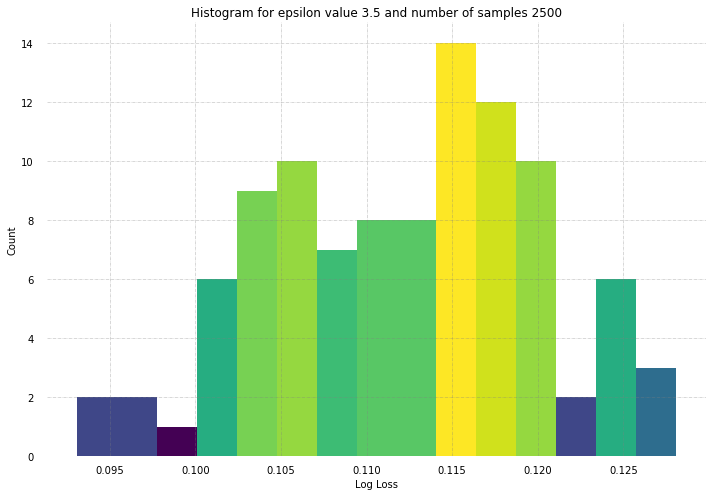

In [184]:
from matplotlib import pyplot as plt
import numpy as np
 
#fig, ax = plt.subplots(figsize =(10, 7))
#ax.hist(loss_final_100,bins = 15,color='red')
fig, axs = plt.subplots(1, 1,
                        figsize =(10, 7),
                        tight_layout = True)
 
for s in ['top', 'bottom', 'left', 'right']:
    axs.spines[s].set_visible(False)
 
axs.xaxis.set_ticks_position('none')
axs.yaxis.set_ticks_position('none')
   
# Add padding between axes and labels
axs.xaxis.set_tick_params(pad = 5)
axs.yaxis.set_tick_params(pad = 10)
 
# Add x, y gridlines
axs.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.6)
 
# Creating histogram
N, bins, patches = axs.hist(loss_final_100, bins = 15)
 
# Setting color
fracs = ((N**(1 / 5)) / N.max())
norm = colors.Normalize(fracs.min(), fracs.max())
 
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)
 
# Show plot
plt.xlabel('Log Loss')
plt.ylabel('Count')
plt.title('Histogram for epsilon value 3.5 and number of samples 2500')
plt.show()

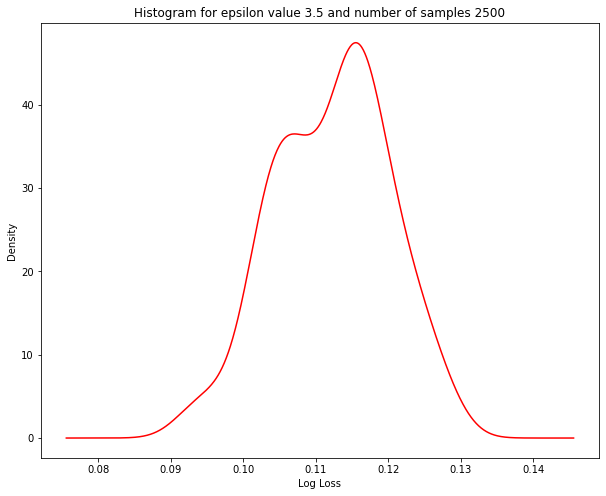

In [192]:
plt.figure(figsize=(10,8))
s = pd.Series(loss_final_100)
ax = s.plot.kde(color='red')
plt.xlabel('Log Loss')
plt.title('Histogram for epsilon value 3.5 and number of samples 2500')
plt.show()

In [67]:
weight_list

[[0, 0, 16000, 16000],
 [1600, 1600, 14400, 14400],
 [3200, 3200, 12800, 12800],
 [4800, 4800, 11200, 11200],
 [6400, 6400, 9600, 9600],
 [8000, 8000, 8000, 8000],
 [9600, 9600, 6400, 6400],
 [11200, 11200, 4800, 4800],
 [12800, 12800, 3200, 3200],
 [14400, 14400, 1600, 1600],
 [16000, 16000, 0, 0]]

In [68]:
loss_final

[[[3, 4.5], nan, 0.5716617865813989, 0.5716617865813989, 1600, [0, 10]],
 [[3, 4.5],
  0.21828836151183928,
  0.5729185939918673,
  0.5374555707438645,
  1600,
  [1, 9]],
 [[3, 4.5],
  0.1982390377813339,
  0.5764202901854228,
  0.500784039704605,
  1600,
  [2, 8]],
 [[3, 4.5],
  0.18068425060085785,
  0.582300989225489,
  0.4618159676380997,
  1600,
  [3, 7]],
 [[3, 4.5],
  0.16203319010359438,
  0.5923738520646871,
  0.42023758728025,
  1600,
  [4, 6]],
 [[3, 4.5],
  0.14327706202249274,
  0.6077890878859669,
  0.3755330749542298,
  1600,
  [5, 5]],
 [[3, 4.5],
  0.12465873301537143,
  0.630780939989296,
  0.32710761580494124,
  1600,
  [6, 4]],
 [[3, 4.5],
  0.105862539163118,
  0.6661518243164104,
  0.2739493247091057,
  1600,
  [7, 3]],
 [[3, 4.5],
  0.08572819606923167,
  0.7277133531186961,
  0.21412522747912452,
  1600,
  [8, 2]],
 [[3, 4.5],
  0.06271501104203528,
  0.8653608234280944,
  0.1429795922806412,
  1600,
  [9, 1]],
 [[3, 4.5], 0.03427716280248951, nan, 0.03427716280

In [69]:
avg_list_loss_adversary1

[nan,
 0.21828836151183928,
 0.1982390377813339,
 0.18068425060085785,
 0.16203319010359438,
 0.14327706202249274,
 0.12465873301537143,
 0.105862539163118,
 0.08572819606923167,
 0.06271501104203528,
 0.03427716280248951]

In [70]:
avg_list_loss_adversary2

[0.5716617865813989,
 0.5729185939918673,
 0.5764202901854228,
 0.582300989225489,
 0.5923738520646871,
 0.6077890878859669,
 0.630780939989296,
 0.6661518243164104,
 0.7277133531186961,
 0.8653608234280944,
 nan]

In [71]:
def function_generator(x,weight_1,weight_2,avg_loss_adversary1,avg_loss_adversary2):
    y=((weight_1*avg_loss_adversary1)+(weight_2*avg_loss_adversary2)-(x*weight_1))/weight_2
    return y

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns


Bad key "text.kerning_factor" on line 4 in
c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [73]:
x=np.linspace(-5,5,100)

In [74]:
y=function_generator(x,1,9,0.13092575714018276, 0.6951862895722297)

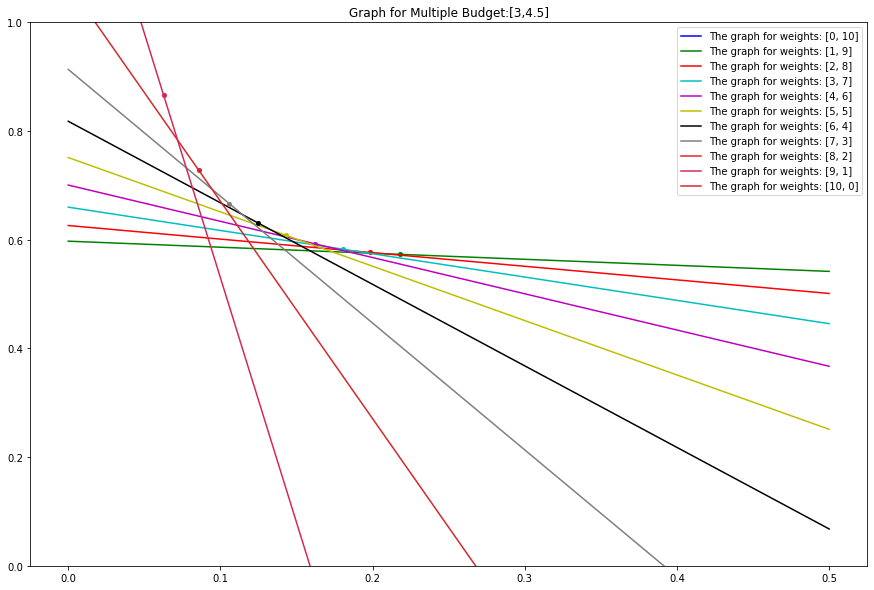

In [81]:
x=np.linspace(0,0.5,100)
weight_1=[0,1,2,3,4,5,6,7,8,9,10]
weight_2=[10,9,8,7,6,5,4,3,2,1,0]
colors=['b','g','r','c','m','y','k','#7f7f7f','#d62728','#d62756','#d62731']
plt.figure(figsize=(15,10))
for i in range(0,len(avg_list_loss_adversary1)):
 y=function_generator(x,weight_1[i],weight_2[i],avg_list_loss_adversary1[i],avg_list_loss_adversary2[i])
 plt.plot(x,y,colors[i],label="The graph for weights: "+str([weight_1[i],weight_2[i]]))
 plt.plot(avg_list_loss_adversary1[i],avg_list_loss_adversary2[i], colors[i], marker='o', markersize=4)
 plt.title("Graph for Multiple Budget:[3,4.5]")
 plt.ylim([0,1])
 plt.legend()



In [76]:
pip install sympy

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\users\dell\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


In [77]:
from sympy import symbols, Eq, solve

In [78]:
def two_equation_calculator(a,b,c,d,e,f):
    x, y = symbols('x y')
    eq1 = Eq(a*x + b*y + c)
    eq2 = Eq(d*x + e*y + f)
    ans=solve((eq1,eq2), (x, y))
    return [ans[x],ans[y]]

In [79]:
two_equation_calculator(2,8,-5.81,1,9,-6.38)


c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: SymPyDeprecationWarning: 

Eq(expr) with a single argument with the right-hand side
defaulting to 0 is deprecated. Use Eq(expr, 0) instead.

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-eq-expr
for details.

This has been deprecated since SymPy version 1.5. It
will be removed in a future version of SymPy.

  This is separate from the ipykernel package so we can avoid doing imports until


[0.125000000000000, 0.695000000000000]

In [1]:
import numpy as np
import matplotlib.pyplot as plt


Bad key "text.kerning_factor" on line 4 in
c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
a=[1,0.2071,0.1895,0.1706,0.152,0.1335,0.1143,0.0945,0.0717,0.0342]
b=[0.5716,0.5741,0.5785,0.5866,0.599,0.6175,0.6463,0.6925,0.7837,1]

In [83]:
avg_list_loss_adversary1

[nan,
 0.21828836151183928,
 0.1982390377813339,
 0.18068425060085785,
 0.16203319010359438,
 0.14327706202249274,
 0.12465873301537143,
 0.105862539163118,
 0.08572819606923167,
 0.06271501104203528,
 0.03427716280248951]

In [84]:
avg_list_loss_adversary1[0]=1

In [3]:
avg_list_loss_adversary1=[1,
 0.21828836151183928,
 0.1982390377813339,
 0.18068425060085785,
 0.16203319010359438,
 0.14327706202249274,
 0.12465873301537143,
 0.105862539163118,
 0.08572819606923167,
 0.06271501104203528,
 0.03427716280248951]

In [86]:
avg_list_loss_adversary2[-1]=1

In [4]:
avg_list_loss_adversary2=[0.5716617865813989,
 0.5729185939918673,
 0.5764202901854228,
 0.582300989225489,
 0.5923738520646871,
 0.6077890878859669,
 0.630780939989296,
 0.6661518243164104,
 0.7277133531186961,
 0.8653608234280944,
 1]

In [5]:
#fill between
#function fill



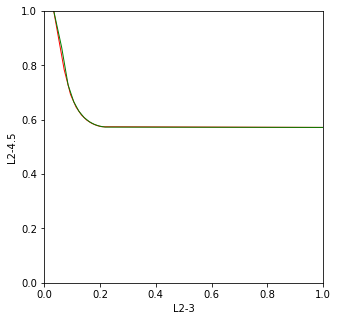

In [7]:
#plt.axhline(0, color='green')
#plt.axvline(0, color='green')
plt.figure(figsize=(5,5))
plt.plot(a, b, '-r', linewidth=1)
plt.plot(avg_list_loss_adversary1,avg_list_loss_adversary2, '-g', linewidth=1)
plt.ylim([0,1])
plt.xlim([0,1])
plt.xlabel('L2-3')
plt.ylabel('L2-4.5')
plt.savefig('L2_Mnist_paper_800_weights.png')

plt.show()

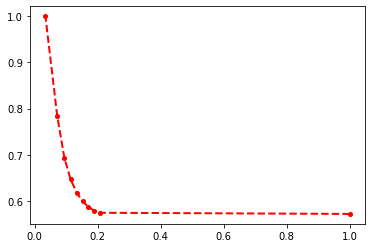

In [92]:
plt.plot(a, b, 'ro--', linewidth=2, markersize=4)

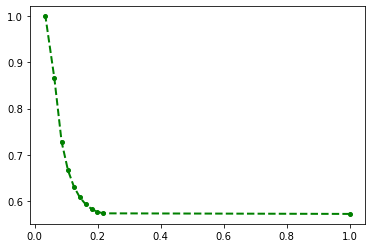

In [93]:
plt.plot(avg_list_loss_adversary1,avg_list_loss_adversary2, 'go--', linewidth=2, markersize=4)